# Scientifically Summarising Star Talk

## Project Overview

StarTalk is a podcast on science, comedy, and popular culture hosted by astrophysicist Neil deGrasse Tyson, with various comic and celebrity co-hosts and frequent guests from the worlds of science and entertainment. It has garnered many spinoffs and tv shows as well as live performances. Whilst the show covers a wide range of topics, it alo gives a platform for scientists working on the frontiers of their fields to communicate where things are going and bring about awareness of otherwise specialised niches.  
 The shows can take anywhere up to 2 and a half hours and, due to the comedic nature and pop culture references, the relevant scientific information can, at times, be sparse. This project seeks to concisely, scientifically summarise Star Talk episodes into a factual report from automated transcriptions by performing unsupervised clustering techniques to establish labels for statements made then filter those labels to provide appropriate inputs for large language model text generation.  
 4 episodes were used for creating the clustering models, whilst a 5th was kept separate and manually labelled for training and testing of the filtration aspect of the clusters. Episodes were tokenised into sentences and the 4 for clustering were merged into a single dataset. Feature engineering was performed to create numeric vectors representing the textual data. These took the form of: 
  * Parts of speech such as verb, noun and adjective counts
  * Individual word counts
  * Term Frequency - Inverse Document Frequency vectors based on words, 2 and 3-grams
  * Word Embedding using Word2Vec on windows of 3 and 6 terms
    
Hierachical Densty Based Spatial Clustering on Applications with Noise (HDBSCAN) was used over a range of minimum cluster size values on each of these vectorisations. The fitted clustering models were then applied to the separated episode and used to predict cluster labels.
 Comparisons with manually assigned labels were made investigating homogeneity as well as accuracy and recall. Counts vectorisation had the worst performance leading to a zero value for recall for cluster sizes greater than 3, and accuracies around 57%. n-gram TF-IDF vectorisation with cluster sizes of 2 and 3-term window word embedding vectors indicated the best results when compared to the manually assigned labels. Whilst TF-IDF word vectorisation with size 10 clusters was not the most accurate on training and testing sets, it had one of the highest recall scores and contributed to one of the best LLM summaries. Models were successfully able to filter inputs for the Mistral LLM text generation algorithm leading to concise scientific summaries.
 Further training of models on more diverse topics will increase the robustness of the process. Investigating other modelling techniques for the cluster filtering, other than majority vote, may also improve performance. This also has the potential to lead to app creation once the processing pipeline is streamlined. Further investigation into broken speech patterns and linkage generation models may also improve continuity handling and nuanced analogy extraction. 
 

## Concept Overview

This project deals with textual data in the form of podcast transcripts. After cleaning and exploring the data, the conversations are tokenised into sentences. One of the episodes is then manually labelled and kept aside for supervised learning. The remaining episodes are then merged and vectorised using parts of speech, word counts, TF-IDF, and word embeddings. The vectorising structures are then applied to the labelled episode. Cluster labels are generated on each vectorization of the merged dataset using HDBSCAN models with varied parameters. Each clustering model is applied to a training proportion of the labelled episode. The resultant cluster distributions are compared with the corresponding manual applied labels and evaluated for homogeneity, accuarcy and recall. Average homogeneity across clusters is used as a metric to select the best clustering models. These models are then applied on the train and test sections to evaluate metrics reports. These models, then applied to complete episodes, are used as filters for input into an LLM summariser. 

## Data Overview

The podcasts contain conversations between at least two parties. Whilst the podcast topic may inherently be scientific in nature, there is a lot of non-scientific (comedic or conversational) components which are included in the transcriptions. The transcriptions are also not perfect representations of the actual words spoken by the parties involved.

#### Data Features

The transcribed text files are in the format:
speaker (time speech began):\nspeech\n\n  
eg:  
0 (1m 49s):  
Surprised that I can even speak to you  

Speakers in the podcast are denoted by integer labels starting at 0, allocated by the order in which they first speak. Some podcasts contain embedded ads in which the speaker label is denoted by the advertiser's name eg Hellmann's. Speech start times are integers in the form of h m s, where hours and minutes are only added once the threshold is reached.

#### Citation

From the 'Podscribe' website, [https://app.podscribe.ai/series/372](https://app.podscribe.ai/series/372) transcriptions of various episodes of the podcast "StarTalk with Neil deGrasse Tyson" were downloaded into .txt files. Episodes were from 2024 series of the podcast including: 
 1.  Quantum Computing Corral_ StarTalk Live! With Michio Kaku
 2.  Synthetic Biological Intelligence with Brett Kagan
 3.  The Magic of Chemistry with Kate the Chemist
 4.  Just Another Really Good Episode with Brian Greene
 5.  Cosmic Queries – Single Electron Universe with Charles Liu

## Data Loading

In [1]:
#pip install scikit-learn==1.0.2 numpy==1.21.6 scipy==1.7.3 matplotlib==3.4.3 gensim==4.0.1

In [2]:
# Import libraries
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [3]:
episode1 = "Quantum Computing Corral_ StarTalk Live! With Michio Kaku-transcript.txt"
episode2 = "Synthetic Biological Intelligence with Brett Kagan-transcript.txt"
episode3 = "The Magic of Chemistry with Kate the Chemist-transcript.txt"
episode4 = "Just Another Really Good Episode with Brian Greene-transcript.txt"
episode5 = "Cosmic Queries – Single Electron Universe with Charles Liu-transcript.txt"

In [4]:
def loader(filename):
    with open(filename,'r') as file:
        content = file.read()
    entries = content.strip().split('\n\n')
    data =[]
    for entry in entries:
        lines = entry.split('\n')
        header = lines[0]
        speaker_time,text = header.split(':',1)
        speaker, time = speaker_time.split('(',1)
        time = time.rstrip(')')
        text = '\n'.join([text.strip()] + lines[1:]).strip()
        data.append({'Speaker': speaker.strip(),'Time':time.strip(),'Text': text.strip()})
    df = pd.DataFrame(data)
    return df

In [5]:
test=loader(episode1)
print(test.iloc[0].Text)
test.head()

You are known as Sarah, the carer. It's why you're picking up your niece from a party at 1:00 AM and after blowing a tire. It's also why you're having a deep and meaningful at one 15. Thankfully, 24 7 roadside assist is included as standard with II's comprehensive car insurance. You'll always be you. So get insurance that's a bit more U-shaped Youi you insured. Product issued by Youi PTY Limited. Consider our car insurance PDS to decide if this product is right for you. Exclusions, limits and additional fees may apply. P ds ts and season tmd. available@youi.com au


,Speaker,Time,Text
0,Youi,0s,"You are known as Sarah, the carer. It's why yo..."
1,1,30s,"Coming. up on StarTalk, we have an episode of ..."
2,1,1m 18s,"Star talk begins right now, Welcome to StarTal..."
3,2,1m 27s,City.
4,1,1m 32s,Tonight we're gonna discuss something that wil...


In [6]:
test.dtypes

Speaker    object
Time       object
Text       object
dtype: object

In [7]:
def ad_clean(df):
    mask = df['Speaker'].astype(str).str.match(r'^\d+$')
    df_filtered = df[mask]
    df_filtered['Speaker'] = df_filtered['Speaker'].astype(int)
    return df_filtered

In [8]:
no_ad_test = ad_clean(test)
print(no_ad_test.dtypes)
no_ad_test.head()

Speaker     int64
Time       object
Text       object
dtype: object


,Speaker,Time,Text
1,1,30s,"Coming. up on StarTalk, we have an episode of ..."
2,1,1m 18s,"Star talk begins right now, Welcome to StarTal..."
3,2,1m 27s,City.
4,1,1m 32s,Tonight we're gonna discuss something that wil...
5,1,2m 13s,And we didn't have to look very far up the str...


In [9]:
ep1=loader(episode1)
ep1=ad_clean(ep1)
ep2=loader(episode2)
ep2=ad_clean(ep2)
ep3=loader(episode3)
ep3=ad_clean(ep3)
ep4=loader(episode4)
ep4=ad_clean(ep4)
ep5=loader(episode5)
ep5=ad_clean(ep5)

In [10]:
print(f"Episode 1 shape: {ep1.shape}")
print(f"Episode 2 shape: {ep2.shape}")
print(f"Episode 3 shape: {ep3.shape}")
print(f"Episode 4 shape: {ep4.shape}")
print(f"Episode 5 shape: {ep5.shape}")

Episode 1 shape: (447, 3)
Episode 2 shape: (236, 3)
Episode 3 shape: (317, 3)
Episode 4 shape: (409, 3)
Episode 5 shape: (329, 3)


## Exploratory Data Analysis

### Episode 1

In [11]:
#!pip install wordcloud

In [12]:
import matplotlib.pyplot as plt
from collections import Counter
import regex as re
import spacy
import numpy as np
from wordcloud import WordCloud
%matplotlib inline

In [13]:
nlp=spacy.load('en_core_web_sm')

In [14]:
custom_words = {'right','okay','yeah','alright','oh','go','yes','thing','say','let','come'}

In [15]:
# Define a function to preprocess text with SpaCy
def preprocess_text(text):
    doc = nlp(text)
    # Remove stopwords and lemmatize tokens
    tokens = [token.lemma_.lower() for token in doc if not token.is_stop and token.is_alpha and token.lemma_.lower() not in custom_words]
    return ' '.join(tokens)


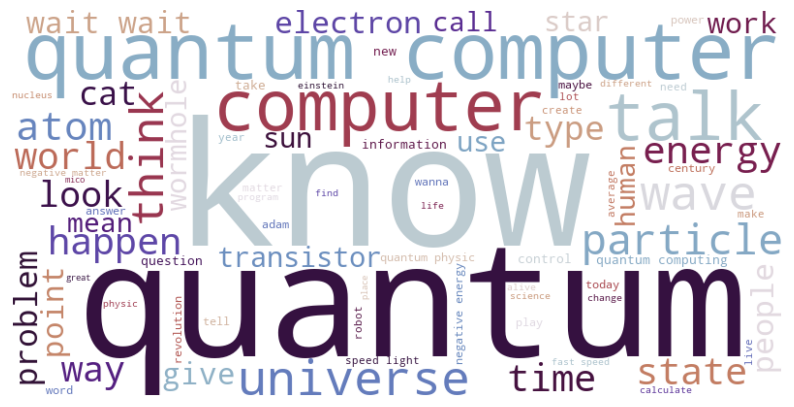

Word: know, Frequency: 1.0
Word: quantum, Frequency: 0.9423076923076923
Word: quantum computer, Frequency: 0.8653846153846154
Word: computer, Frequency: 0.8269230769230769
Word: talk, Frequency: 0.7692307692307693


In [16]:
# Apply preprocessing to each text in the dataframe
ep1['Short'] = ep1['Text'].apply(preprocess_text)

# Concatenate cleaned text from all rows
ep1_corpus = ' '.join(ep1['Short'])

# Plot wordcloud
wordcloud1 = WordCloud(width=800, height=400, background_color='white',max_words=80,colormap='twilight_shifted',random_state=94).generate(ep1_corpus)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud1, interpolation='bilinear')
plt.axis('off')
plt.show()
# Get word frequencies from the word cloud
word_frequencies1 = wordcloud1.words_

# Find the largest words based on frequency
largest_words1 = sorted(word_frequencies1.items(), key=lambda item: item[1], reverse=True)[:5]

# Print the largest words
for word, freq in largest_words1:
    print(f"Word: {word}, Frequency: {freq}")

### Episode 2

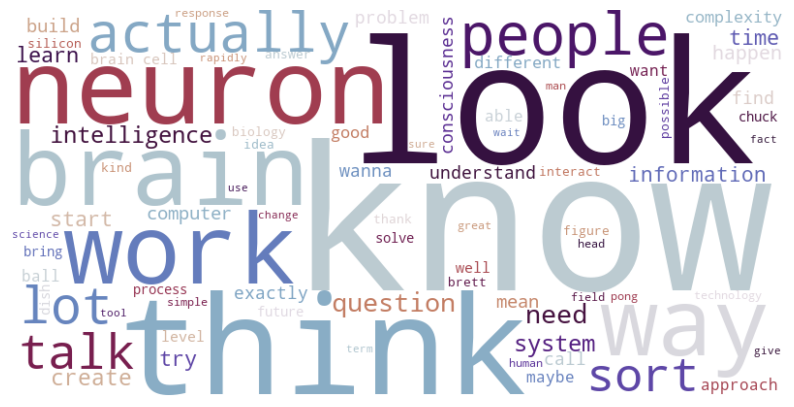

Word: know, Frequency: 1.0
Word: look, Frequency: 0.7121212121212122
Word: think, Frequency: 0.6060606060606061
Word: neuron, Frequency: 0.5454545454545454
Word: brain, Frequency: 0.48484848484848486


In [17]:
# Apply preprocessing to each text in the dataframe
ep2['Short'] = ep2['Text'].apply(preprocess_text)

# Concatenate cleaned text from all rows
ep2_corpus = ' '.join(ep2['Short'])

# Plot wordcloud
wordcloud2 = WordCloud(width=800, height=400, background_color='white',max_words=80,colormap='twilight_shifted',random_state=94).generate(ep2_corpus)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud2, interpolation='bilinear')
plt.axis('off')
plt.show()
# Get word frequencies from the word cloud
word_frequencies2 = wordcloud2.words_

# Find the largest words based on frequency
largest_words2 = sorted(word_frequencies2.items(), key=lambda item: item[1], reverse=True)[:5]

# Print the largest words
for word, freq in largest_words2:
    print(f"Word: {word}, Frequency: {freq}")

### Episode 3

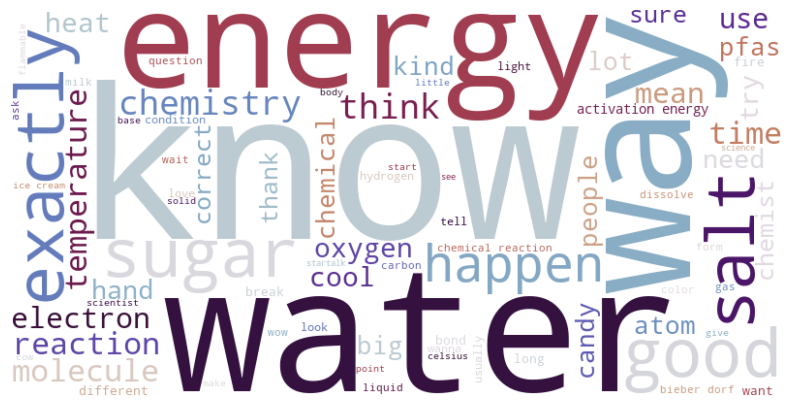

Word: know, Frequency: 1.0
Word: water, Frequency: 0.6595744680851063
Word: way, Frequency: 0.5319148936170213
Word: energy, Frequency: 0.5106382978723404
Word: good, Frequency: 0.48936170212765956


In [18]:
# Apply preprocessing to each text in the dataframe
ep3['Short'] = ep3['Text'].apply(preprocess_text)

# Concatenate cleaned text from all rows
ep3_corpus = ' '.join(ep3['Short'])

# Plot wordcloud
wordcloud3 = WordCloud(width=800, height=400, background_color='white',max_words=80,colormap='twilight_shifted',random_state=94).generate(ep3_corpus)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud3, interpolation='bilinear')
plt.axis('off')
plt.show()
# Get word frequencies from the word cloud
word_frequencies3 = wordcloud3.words_

# Find the largest words based on frequency
largest_words3 = sorted(word_frequencies3.items(), key=lambda item: item[1], reverse=True)[:5]

# Print the largest words
for word, freq in largest_words3:
    print(f"Word: {word}, Frequency: {freq}")

### Episode 4

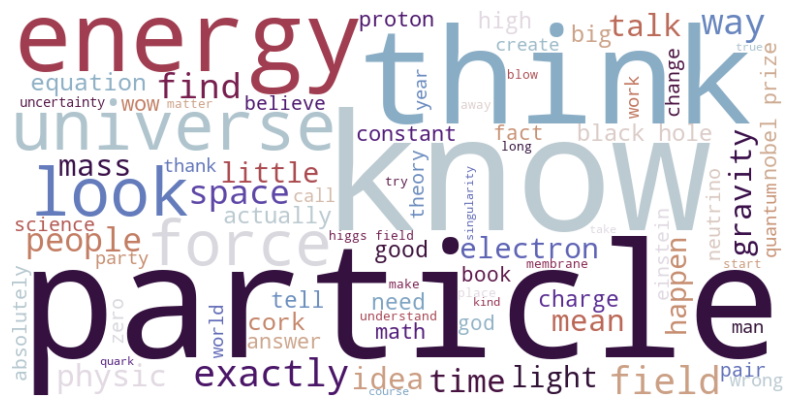

Word: know, Frequency: 1.0
Word: particle, Frequency: 0.967741935483871
Word: think, Frequency: 0.6451612903225806
Word: energy, Frequency: 0.5645161290322581
Word: universe, Frequency: 0.5483870967741935


In [19]:
# Apply preprocessing to each text in the dataframe
ep4['Short'] = ep4['Text'].apply(preprocess_text)

# Concatenate cleaned text from all rows
ep4_corpus = ' '.join(ep4['Short'])

# Plot wordcloud
wordcloud4 = WordCloud(width=800, height=400, background_color='white',max_words=80,colormap='twilight_shifted',random_state=94).generate(ep4_corpus)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud4, interpolation='bilinear')
plt.axis('off')
plt.show()
# Get word frequencies from the word cloud
word_frequencies4 = wordcloud4.words_

# Find the largest words based on frequency
largest_words4 = sorted(word_frequencies4.items(), key=lambda item: item[1], reverse=True)[:5]

# Print the largest words
for word, freq in largest_words4:
    print(f"Word: {word}, Frequency: {freq}")

### Episode 5

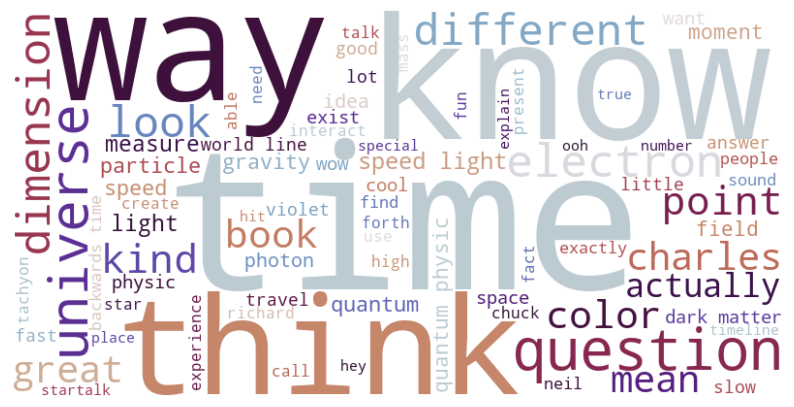

Word: time, Frequency: 1.0
Word: know, Frequency: 0.686046511627907
Word: way, Frequency: 0.5581395348837209
Word: think, Frequency: 0.5
Word: question, Frequency: 0.45348837209302323


In [20]:
# Apply preprocessing to each text in the dataframe
ep5['Short'] = ep5['Text'].apply(preprocess_text)

# Concatenate cleaned text from all rows
ep5_corpus = ' '.join(ep5['Short'])

# Plot wordcloud
wordcloud5 = WordCloud(width=800, height=400, background_color='white',max_words=80,colormap='twilight_shifted',random_state=94).generate(ep5_corpus)

plt.figure(figsize=(10, 8))
plt.imshow(wordcloud5, interpolation='bilinear')
plt.axis('off')
plt.show()
# Get word frequencies from the word cloud
word_frequencies5 = wordcloud5.words_

# Find the largest words based on frequency
largest_words5 = sorted(word_frequencies5.items(), key=lambda item: item[1], reverse=True)[:5]

# Print the largest words
for word, freq in largest_words5:
    print(f"Word: {word}, Frequency: {freq}")

### Sentence Tokenising

In [21]:
#create a function to expand the dataframe so that each sentence is a new observation:
def sentencer(df):
    rows = []
    
    for idx, row in df.iterrows():
        speaker = row['Speaker']
        time = row['Time']
        # Split by period, question mark or exclamation mark and space to get sentences
        sentences = re.split(r'(?<!\bDr)(?<!\bDr\.)(?<=[.?!])\s+', row['Text'])        
        for sentence in sentences:
            cleaned_sentence = sentence.strip()
            if cleaned_sentence:
                rows.append({'Speaker': speaker, 'Time': time, 'Text': cleaned_sentence})
    
    return pd.DataFrame(rows)


In [22]:
ep1_sent = sentencer(ep1)
ep2_sent = sentencer(ep2)
ep3_sent = sentencer(ep3)
ep4_sent = sentencer(ep4)
ep5_sent = sentencer(ep5)
print(f"ep1_sent shape: {ep1_sent.shape}\nep2_sent shape: {ep2_sent.shape}\nep3_sent shape: {ep3_sent.shape}\nep4_sent shape: {ep4_sent.shape}\nep5_sent shape: {ep5_sent.shape}\n")

ep1_sent shape: (1400, 3)
ep2_sent shape: (855, 3)
ep3_sent shape: (1423, 3)
ep4_sent shape: (1650, 3)
ep5_sent shape: (1106, 3)



### Manually Labelled Episode

In [23]:
#Convert ep1_sent to csv format to label externally and be used as a test set
ep1_sent.to_csv('ep1_sent.csv',index=False)
print(f"DataFrame 'ep1_sent' successfully saved as CSV file: 'ep1_sent.csv'")

DataFrame 'ep1_sent' successfully saved as CSV file: 'ep1_sent.csv'


In [24]:
ep1_labelled = pd.read_csv('ep1_sent_labelled.csv',header=0)
ep1_labelled.head()

,Speaker,Time,Text,Label
0,1,30s,Coming,0
1,1,30s,"up on StarTalk, we have an episode of StarTalk...",1
2,1,30s,"My co-host, Jordan Klepper You, know him from ...",0
3,1,30s,"Also as my guest, my friend and colleague, Mic...",1
4,1,30s,And we talk about the future of quantum comput...,1


##### Label proportions

In [25]:
print(f"The proportion of sentences manually labelled as relevant in episode 1 is {round(ep1_labelled['Label'].sum()/ep1_labelled.shape[0],4)}")

The proportion of sentences manually labelled as relevant in episode 1 is 0.4214


##### Word Distributions by Label

###### All words

In [26]:
# Create a corpus for each label
ep1_corpus_1 = ' '.join(ep1_labelled.loc[ep1_labelled['Label'] == 1, 'Text'].tolist())
ep1_corpus_0 = ' '.join(ep1_labelled.loc[ep1_labelled['Label'] == 0, 'Text'].tolist())
# Create a lemmatised token document for each label with all words
doc11 = nlp(' '.join([token.lemma_.lower() for token in nlp(ep1_corpus_1) if token.is_alpha and not token.is_punct]))
doc10 = nlp(' '.join([token.lemma_.lower() for token in nlp(ep1_corpus_0) if token.is_alpha and not token.is_punct]))
# Create a lemmatised token document for each label without stop words
doc21 = nlp(preprocess_text(ep1_corpus_1))
doc20 = nlp(preprocess_text(ep1_corpus_0))

In [27]:
def plot_words(tokens, top = 40):
    tokens_counter = Counter(tokens)
    tok = [t for (t, _) in tokens_counter.most_common()]
    val = [v for (_, v) in tokens_counter.most_common()]

    plt.figure(figsize = (16, 6))
    plt.bar(tok[:top], val[:top])
    plt.title('Number of terms: %d' % len(tokens_counter))
    plt.ylabel('Count')
    plt.xticks(rotation = 90)

    plt.show()

Word distribution for label = 1


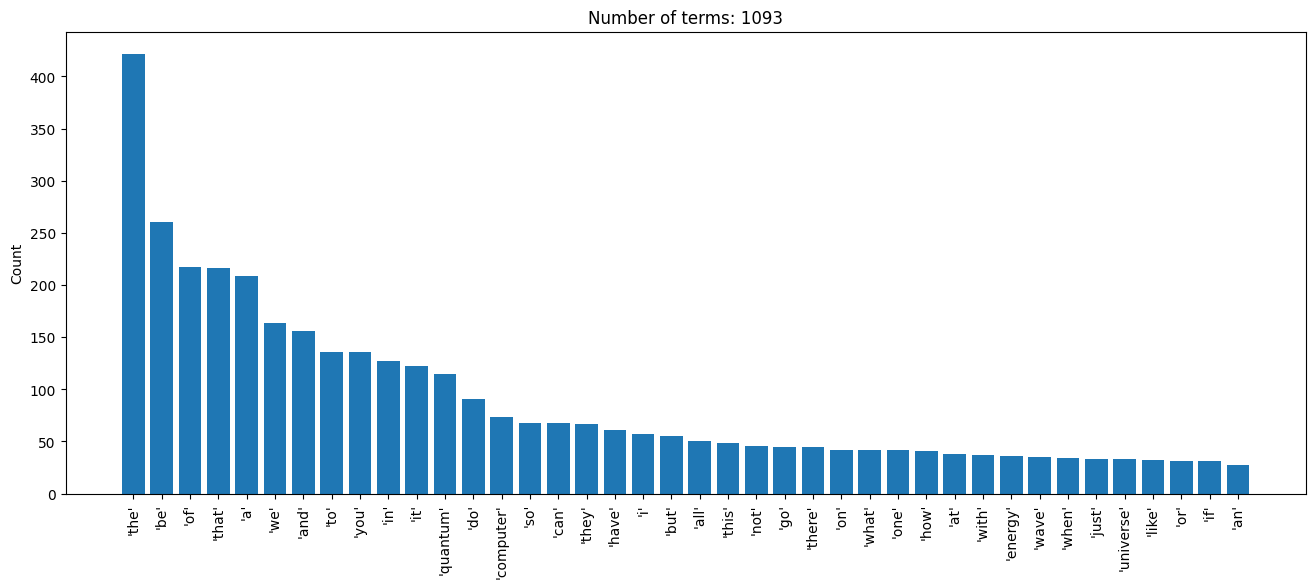

In [28]:
print("Word distribution for label = 1\n===============================")
plot_words(['%r' % t.text for t in doc11])

Word distribution for label = 0


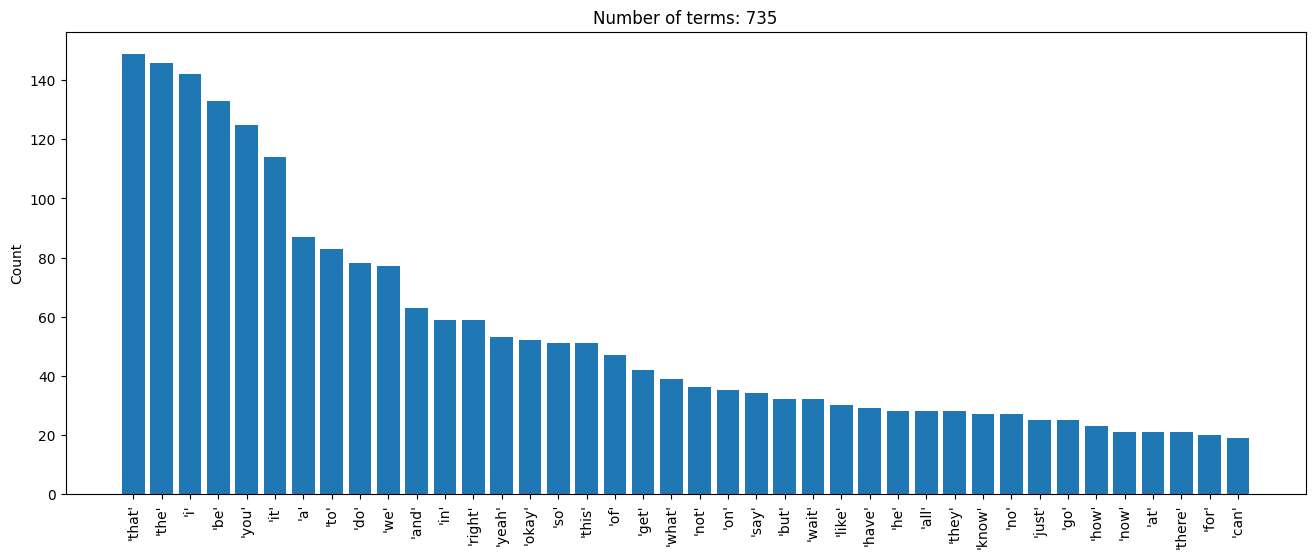

In [29]:
print("Word distribution for label = 0\n===============================")
plot_words(['%r' % t.text for t in doc10])

###### With Stopwords removed

Word distribution for label = 1


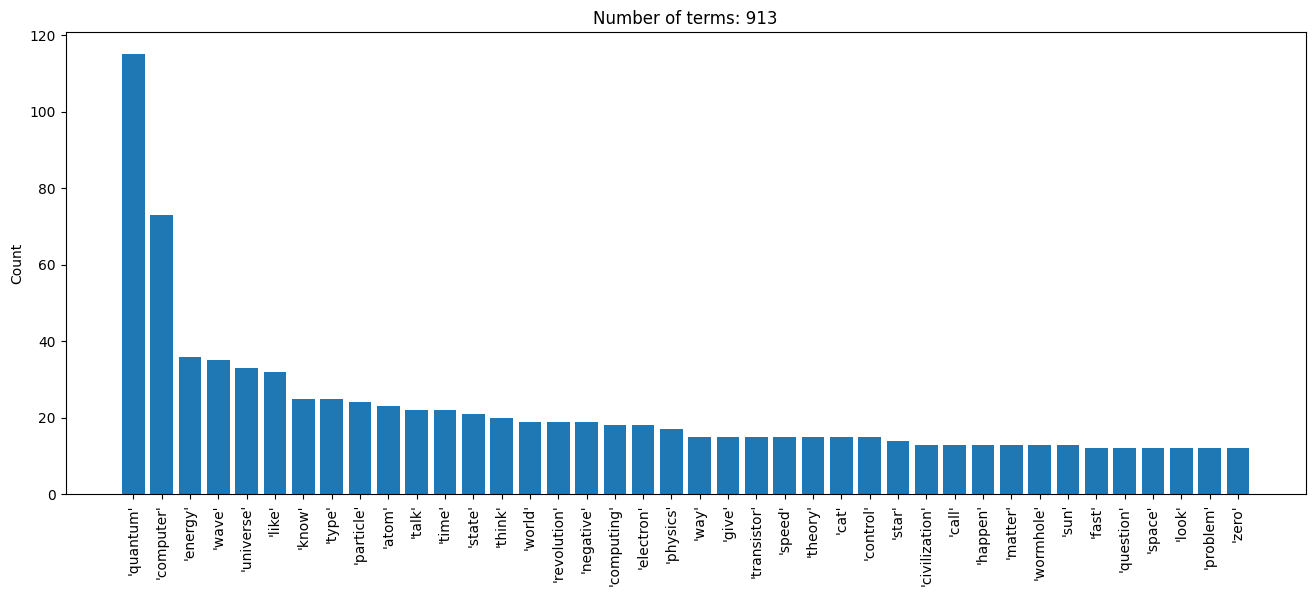

In [30]:
print("Word distribution for label = 1\n===============================")
plot_words(['%r' % t.text for t in doc21])

Word distribution for label = 0


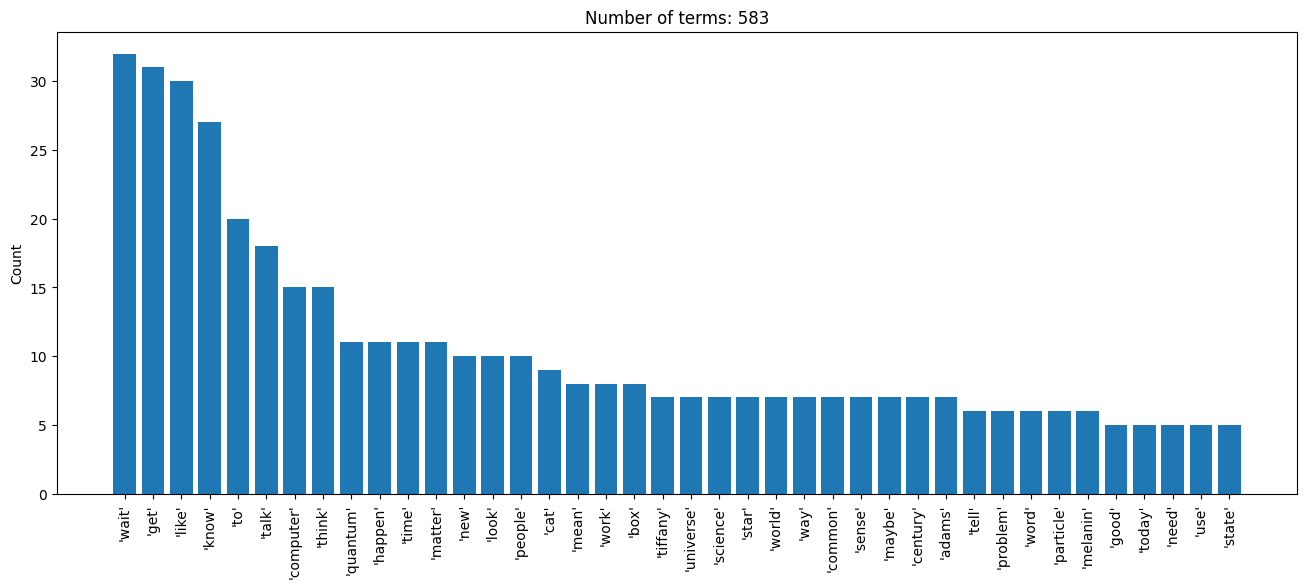

In [31]:
print("Word distribution for label = 0\n===============================")
plot_words(['%r' % t.text for t in doc20])

## Feature Engineering

In [32]:
import string
from sklearn.preprocessing import StandardScaler

In [33]:
# Assign a source variable
ep1_sent=ep1_sent.assign(source='episode 1')
ep2_sent=ep2_sent.assign(source='episode 2')
ep3_sent=ep3_sent.assign(source='episode 3')
ep4_sent=ep4_sent.assign(source='episode 4')
ep5_sent=ep5_sent.assign(source='episode 5')

In [34]:
# Concatenate the sentence level tokenised episodes 2 - 5 into a training dataframe
TrainDF = pd.concat([ep2_sent,ep3_sent,ep4_sent,ep5_sent],ignore_index=True)
TrainDF

,Speaker,Time,Text,source
0,0,0s,Coming up on StarTalk special edition.,episode 2
1,0,0s,Rather than attach computers to your brains.,episode 2
2,0,0s,What happens if a computer is made of the buil...,episode 2
3,0,0s,Blocks of brains themselves?,episode 2
4,0,0s,Coming up on special edition Welcome to talk.,episode 2
...,...,...,...,...
5029,0,54m 57s,And it at better bookstores near you.,episode 5
5030,0,54m 57s,"Alright, Chuck, always good to have you, man.",episode 5
5031,0,54m 57s,Always a pleasure.,episode 5
5032,0,54m 57s,Neil deGrasse Tyson here.,episode 5


### Parts of Speech Features

Establish parts of speech vectors for each sentence in the episodes, incorporating counts for total characters, total words, word density, punctuation, title words, uppercase words, proper nouns, verbs, nouns, adjectives and interjections. Fit a unique standard scaler model to each column of the training episodes then apply to the labelled episode.   

In [35]:
#Function to return dataframe of parts of speech vectors from an input dataframe
def pos(DF):
    pos_list=['char_count',
          'word_count',
          'word_density',
          'punctuation_count',
          'title_word_count',
          'uppercase_word_count',
          'proper_noun_count',
          'verb_count', 
          'noun_count', 
          'adj_count', 
          'intj_count']
    tempDF = pd.DataFrame()
    tempDF['char_count'] = DF['Text'].apply(lambda x: len(x))
    tempDF['word_count'] = DF['Text'].apply(lambda x: len(x.split()))
    tempDF['word_density'] = tempDF['char_count'] / tempDF['word_count']
    tempDF['punctuation_count'] = DF['Text'].apply(lambda x: sum(1 for char in x if char in string.punctuation))
    tempDF['title_word_count'] = DF['Text'].apply(lambda x: len(re.findall(r'\b[A-Z][a-z]*\b', x)))
    tempDF['uppercase_word_count'] = DF['Text'].apply(lambda x: len(re.findall(r'\b[A-Z]+\b', x)))
    tempDF['proper_noun_count'] = DF['Text'].apply(lambda x: sum(1 for token in nlp(x) if token.pos_ =='PROPN'))
    tempDF['verb_count'] = DF['Text'].apply(lambda x: sum(1 for token in nlp(x) if token.pos_ =='VERB'))
    tempDF['noun_count'] = DF['Text'].apply(lambda x: sum(1 for token in nlp(x) if token.pos_ =='NOUN'))
    tempDF['adj_count'] = DF['Text'].apply(lambda x: sum(1 for token in nlp(x) if token.pos_ =='ADJ'))
    tempDF['intj_count'] = DF['Text'].apply(lambda x: sum(1 for token in nlp(x) if token.pos_ =='INTJ'))

    return tempDF

In [37]:
#Evaluate temporary dataframe for P.O.S. vectors for Training episodes
tempDF = pos(TrainDF)

In [38]:
#Evaluate dataframe for P.O.S. vectors on labelled episode
ep1DF =pos(ep1_labelled)

In [39]:
#Function to create a unique scaler model for a column index of the P.O.S. vector dataframe
def scales(DF,ind):
    scaler=StandardScaler()
    scaler= scaler.fit(DF.iloc[:,[ind]])
    return scaler

In [40]:
#Fit scaler models for each feature of the training episodes:
scalers=[scales(tempDF,0),
         scales(tempDF,1),
         scales(tempDF,2),
         scales(tempDF,3),
         scales(tempDF,4),
         scales(tempDF,5),
         scales(tempDF,6),
         scales(tempDF,7),
         scales(tempDF,8),
         scales(tempDF,9),
         scales(tempDF,10)]

In [41]:
# Function to transform P.O.S. vector dataframe columns using individual scaler models
def apply_scalers(DF, scalers):
    transformed_cols = []
    for i, scaler in enumerate(scalers):
        transformed_col = scaler.transform(DF.iloc[:, [i]])  # Apply scaler to column i
        transformed_cols.append(transformed_col)

    transformed_df = pd.DataFrame(
        data=np.concatenate(transformed_cols, axis=1),
        columns=DF.columns
    )

    return transformed_df

In [42]:
# Create dataframes of scaled P.O.S. features separately for the training episodes and the labelled episode.
pos_feat = apply_scalers(tempDF,scalers)
ep1posDF = apply_scalers(ep1DF,scalers)

### Count Vectors as features

Establish word count vectors based on the training episodes. Once fitted to the training episodes, apply these vectors to the labelled episode.

In [43]:
from sklearn.feature_extraction.text import CountVectorizer

In [44]:
# create a count vectorizer object
count_vect = CountVectorizer(token_pattern = r'\w{1,}')

# Fit and transform documents to document-term matrix.
TrainDF_count = count_vect.fit_transform(TrainDF['Text'])

In [45]:
#Transform the labelled episode into a document-term matrix
ep1_count = count_vect.transform(ep1_labelled['Text'])

### TF-IDF Vectors as features

Establish TF-IDF vectors based on the training episodes; one vectorisation base on words with stopwords removed and another based on 2 and 3-grams with all words used to maintain context. Once fitted to the training episodes, apply these vectorisations to the labelled episode.

In [46]:
from sklearn.feature_extraction.text import TfidfVectorizer
import warnings
warnings.filterwarnings('ignore')

In [47]:
#Create custom stopword list combining default stopwords with custom words discovered in EDA.
stopwords_ = list(nlp.Defaults.stop_words.union(custom_words))

#### Word level

In [48]:
# Instantiate and train on training episodes

In [49]:
%%time
# word level tf-idf
tfidf_vect = TfidfVectorizer(stop_words=stopwords_,
                             analyzer = 'word',
                             token_pattern = r'\w{1,}',
                             max_features = 5000)
print(tfidf_vect)

X = tfidf_vect.fit_transform(TrainDF['Text'])


TfidfVectorizer(max_features=5000,
                stop_words=['we', 'six', 'as', 'few', 'no', 'ever', 'anyway',
                            'became', 'now', 'another', 'bottom', 'other',
                            'someone', 'per', 'whoever', 'three', 'everything',
                            'if', 'thereby', 'every', 'never', 'ca', 'from',
                            '’m', 'fifteen', 'hence', 'seeming', 'thing',
                            'itself', 'thus', ...],
                token_pattern='\\w{1,}')
CPU times: user 56.9 ms, sys: 3.29 ms, total: 60.2 ms
Wall time: 61 ms


In [50]:
#Apply to labelled episode
ep1_X = tfidf_vect.transform(ep1_labelled['Text'])

#### n-gram level

In [51]:
# Instantiate and train on training episodes

In [52]:
%%time
# ngram level tf-idf
tfidf_vect_ngram = TfidfVectorizer(analyzer = 'word',
                                   token_pattern = r'\w{1,}',
                                   ngram_range = (2, 3),
                                   max_features = 5000)
print(tfidf_vect_ngram)

Xng = tfidf_vect_ngram.fit_transform(TrainDF['Text'])

TfidfVectorizer(max_features=5000, ngram_range=(2, 3), token_pattern='\\w{1,}')
CPU times: user 212 ms, sys: 10.3 ms, total: 222 ms
Wall time: 225 ms


In [53]:
#Apply to labelled episode
ep1_Xng = tfidf_vect_ngram.transform(ep1_labelled['Text'])

In [86]:
type(Xng)

scipy.sparse._csr.csr_matrix

### Word Embedding Vectors as Features

Preprocess the conversations by tokenising and lowering each sentence to create lists of lists of tokens for both the training episodes and the labelled episode. Apply a gensim Word2Vec vectorising model to the preprocessed training episodes set Establish TF-IDF vectors based on the training episodes; one vectorisation base on words with stopwords removed and another based on 2 and 3-grams with all words used to maintain context. Once fitted to the training episodes, apply these vectorisations to the labelled episode.

In [54]:
#pip install gensim

In [55]:
import gensim
gensim.__version__

'4.3.0'

In [56]:
#Function to tokenise and lower text
def tokenise_and_lower(text):
    doc = nlp(text)
    tokens = [token.text.lower() for token in doc]
    return tokens


In [57]:
tk1=TrainDF['Text'].apply(tokenise_and_lower)

In [58]:
tkep1=ep1_labelled['Text'].apply(tokenise_and_lower)

#### 6-word window

In [59]:
#Train word2vec model with window = 6
W2Vmodel = gensim.models.Word2Vec(sentences=tk1, vector_size=100, window=6, min_count=1, workers=4, seed=94)

In [178]:
def average_word_vectors(tokens, model, vocabulary, vector_size):
    word_vectors = [model.wv[word] for word in tokens if word in vocabulary]
    if word_vectors:
        return np.mean(word_vectors, axis=0)
    else:
        return np.zeros(vector_size)


In [179]:
#Get document vectors for training episodes
document_vectors = [
    average_word_vectors(sentence, W2Vmodel, W2Vmodel.wv.index_to_key, vector_size=100)
    for sentence in tk1
]

In [180]:
#Get document vectors for labelled episode
ep1_doc_vecs = [
    average_word_vectors(sentence, W2Vmodel, W2Vmodel.wv.index_to_key, vector_size=100)
    for sentence in tkep1
]

#### 3-word window

In [63]:
#Train word2vec model with window = 3
W2Vmodel2 = gensim.models.Word2Vec(sentences=tk1, vector_size=100, window=3, min_count=1, workers=4, seed=94)

In [181]:
#Get document vectors for training episodes
document_vectors2 = [
    average_word_vectors(sentence, W2Vmodel2, W2Vmodel2.wv.index_to_key, vector_size=100)
    for sentence in tk1
]

In [182]:
#Get document vectors for labelled episode
ep1_doc_vecs2 = [
    average_word_vectors(sentence, W2Vmodel2, W2Vmodel2.wv.index_to_key, vector_size=100)
    for sentence in tkep1
]

## Unsupervised learning

Using a range of values for min_cluster_size, perform clustering using HDBScan on each of the vector sets derived from the training episodes. Save the models and explore the modelled clusters.

In [66]:
#pip install hdbscan

In [90]:
import hdbscan
import random
from scipy.sparse import issparse

In [87]:
# Function to evaluate number of labels and number of unclustered instances for a minimum cluster size instance of HDBSCAN
def hdbscanner(input,ms):
    np.random.seed(94) #Set seed
    if issparse(input):
        input = input.toarray()
    hdb = hdbscan.HDBSCAN(min_cluster_size=ms, prediction_data=True,core_dist_n_jobs=-1).fit(input) 
    cluster_labels=hdb.labels_ #retrieve the labels
    cluster_counts = pd.Series(cluster_labels).value_counts() #retrieve counts for each label
    uncluster_count = cluster_counts.get(-1,0) #count unclustered sentences (label=-1)
    print(f"min_size:{ms} unclustered:{uncluster_count}  number of labels:{pd.Series(cluster_labels).nunique()}")
    return hdb,cluster_labels

In [69]:
# Function to provide a sample of sentences grouped into each cluster label 
def cluster_explainer(clusterlabs,df,val,samp=3):
    ''' 
    Takes in cluster labels, the dataframe that the text came from, the value of the highest cluster 
    label or list of clusters to evaluate and the number of samples to show for each cluster. It then
    determines if the "val" input is the highest cluster label or a list of cluster labels to sample. 
    If "val" is an integer, it checks if there are instances of label "-1" (noise) and adjusts the 
    iterable range accordingly. It iterates over the range of labels and checks if there are sufficient 
    instances of each label to match the required sample size and returns the random sample or all 
    instances, whichever is smaller.'''
    np.random.seed(94)
    print("cluster text example\n======= ============")
    if isinstance(val,int):
        start_label = -1 if -1 in clusterlabs else 0 #determine starting value for clusters (are there unclustered entries)
        scope = range(start_label,val+1)
    else:
        scope = val
    for label in scope: #loop over all labels
        potential= clusterlabs==label #boolean for instances with label
        if np.sum(potential) < samp: #are there less instances than the desired sample size
            samples = df.loc[clusterlabs==label,'Text'].sample(n=np.sum(potential))
        else:
            samples = df.loc[clusterlabs==label,'Text'].sample(n=samp)
        joint_samples = ' '.join(samples)
        print(f"{label}       {joint_samples}")

In [70]:
# Function to see distribution of cluster labels and find the labels with counts over a threshold
def cluster_eval(clusterlabs,thresh=40):
    cluster_counts = pd.Series(clusterlabs).groupby(TrainDF['source']).value_counts().unstack(fill_value=0) #label counts by source
    subset_cols = cluster_counts.columns[cluster_counts.sum() > thresh] #labels with counts exceeding threshold
    print(f"There are {len(subset_cols)} groups with counts greater than {thresh}. They are:")
    print(subset_cols)
    plt.figure(figsize=(10, 6))
    for idx, row in cluster_counts.iterrows():
        x_values = cluster_counts.columns  # Get the x-values from labels
        y_values = row.values  # Get the y-values from the counts
        plt.plot(x_values, y_values, label=idx)  # Plot each row with a label

    plt.xlabel('Cluster Labels')
    plt.ylabel('Counts')
    plt.title('Cluster distributions by episode')
    plt.legend()  # Show legend with source names
    plt.axhline(y=thresh, color='black', linestyle='--')
    plt.grid(True)
    plt.show()
    return cluster_counts

### HDBScan on Parts of Speech

In [91]:
pos_clusters=pd.DataFrame()

In [92]:
%%time
pos_mod2, pos_clusters['2'] = hdbscanner(pos_feat,2)
pos_mod3, pos_clusters['3'] = hdbscanner(pos_feat,3)
pos_mod4, pos_clusters['4'] = hdbscanner(pos_feat,4)
pos_mod5, pos_clusters['5'] = hdbscanner(pos_feat,5)
pos_mod6, pos_clusters['6'] = hdbscanner(pos_feat,6)
pos_mod7, pos_clusters['7'] = hdbscanner(pos_feat,7)
pos_mod8, pos_clusters['8'] = hdbscanner(pos_feat,8)
pos_mod9, pos_clusters['9'] = hdbscanner(pos_feat,9)
pos_mod10, pos_clusters['10'] = hdbscanner(pos_feat,10)

min_size:2 unclustered:1484  number of labels:512
min_size:3 unclustered:1642  number of labels:250
min_size:4 unclustered:1817  number of labels:186
min_size:5 unclustered:2020  number of labels:135
min_size:6 unclustered:2177  number of labels:110
min_size:7 unclustered:2194  number of labels:97
min_size:8 unclustered:2331  number of labels:78
min_size:9 unclustered:2339  number of labels:72
min_size:10 unclustered:2422  number of labels:67
CPU times: user 10.6 s, sys: 67.1 ms, total: 10.6 s
Wall time: 10.6 s


There are 6 groups with counts greater than 40. They are:
Int64Index([-1, 32, 68, 69, 75, 77], dtype='int64', name='2')


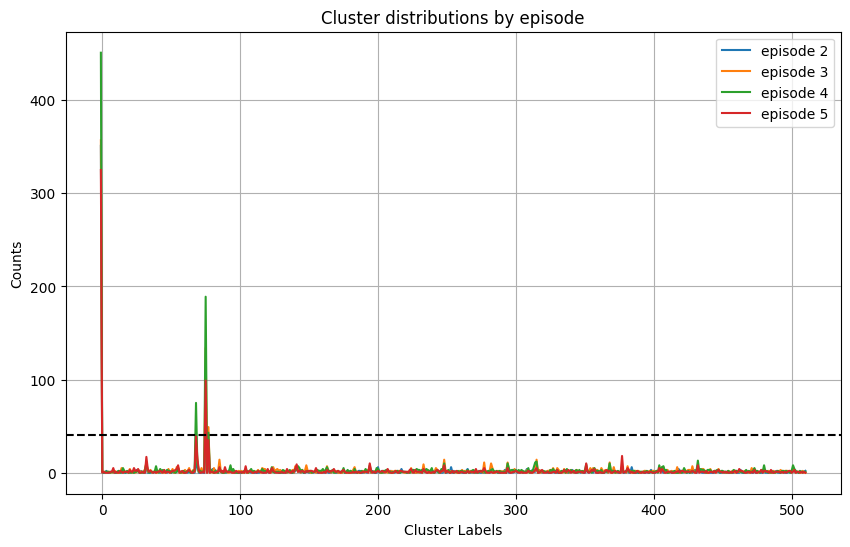

In [93]:
cc = cluster_eval(pos_clusters['2'])

In [94]:
cluster_explainer(pos_clusters['2'],TrainDF,[-1, 32, 68, 69, 75, 77],3)

cluster text example
======= ============
-1       And we met in relativity class, really taught by John Wheeler. So you think, who knows what sort of quantum phone So what's the biggest source of PFAS into our system?
32       So here, I'll, I'll go for I don't know, I'm just making something up. I'm, I'm born.
68       Right. Right. Right.
69       Oh, Mm. Mm.
75       Yeah. Yeah. Okay.
77       Yes. Yes. Yes.


There are 13 groups with counts greater than 40. They are:
Int64Index([-1, 7, 11, 15, 16, 17, 18, 19, 23, 24, 34, 84, 103], dtype='int64', name='6')


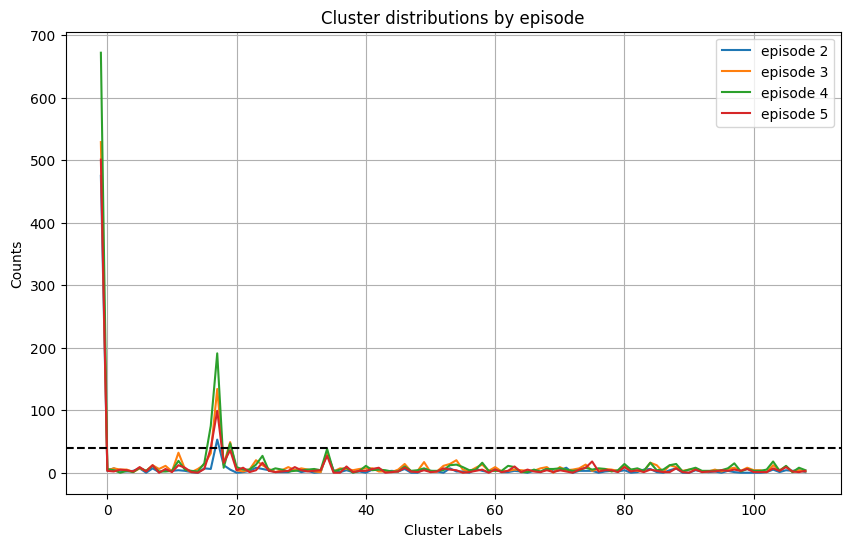

In [95]:
cc = cluster_eval(pos_clusters['6'])

In [96]:
cluster_explainer(pos_clusters['6'],TrainDF,[-1, 7, 11, 15, 16, 17, 18, 19, 23, 24, 34, 84, 103],3)

cluster text example
======= ============
-1       We, oh yeah. There it's You know my son started off with just chemistry and liked it so much that he's going to school now for biochem. It's a fuzz ball, you can have a fuzz ball or corks
7       Yeah, we go through very versions of that. The same, okay. Yeah, all of those are, are great questions.
11       You know what I mean? What happens if I put a hunk of sodium in water? And so I'm gonna jump into some thermodynamics.
15       In the beginning, yes. Yeah, universe. That's yeah.
16       Right. Right. Right.
17       Okay. Yeah. Okay.
18       No, No. No.
19       Hmm. But yes. Yes.
23       I influence on it. I promise you. I know him.
24       So this is Alan rarer. Coming up on special edition Welcome to talk. Whereas Beyonce walks in, everybody will crowd around here.
34       Stupid human eyes. So chemistry in general is the study of energy and matter and how they interact with each other. Scientists active in some thing that

### HDBScan on TF-IDF

#### Words

In [97]:
TFIDFword_clusters = pd.DataFrame()

In [98]:
%%time
TFIDFword_mod2, TFIDFword_clusters['2'] = hdbscanner(X,2)
TFIDFword_mod3, TFIDFword_clusters['3'] = hdbscanner(X,3)
TFIDFword_mod4, TFIDFword_clusters['4'] = hdbscanner(X,4)
TFIDFword_mod5, TFIDFword_clusters['5'] = hdbscanner(X,5)
TFIDFword_mod6, TFIDFword_clusters['6'] = hdbscanner(X,6)
TFIDFword_mod7, TFIDFword_clusters['7'] = hdbscanner(X,7)
TFIDFword_mod8, TFIDFword_clusters['8'] = hdbscanner(X,8)
TFIDFword_mod9, TFIDFword_clusters['9'] = hdbscanner(X,9)
TFIDFword_mod10, TFIDFword_clusters['10'] = hdbscanner(X,10)

min_size:2 unclustered:2386  number of labels:273
min_size:3 unclustered:2714  number of labels:143
min_size:4 unclustered:2966  number of labels:84
min_size:5 unclustered:3077  number of labels:59
min_size:6 unclustered:3173  number of labels:47
min_size:7 unclustered:3230  number of labels:34
min_size:8 unclustered:3256  number of labels:29
min_size:9 unclustered:3312  number of labels:23
min_size:10 unclustered:3322  number of labels:21
CPU times: user 32min 4s, sys: 11.5 s, total: 32min 15s
Wall time: 32min 13s


There are 4 groups with counts greater than 40. They are:
Int64Index([-1, 75, 243, 252], dtype='int64', name='2')


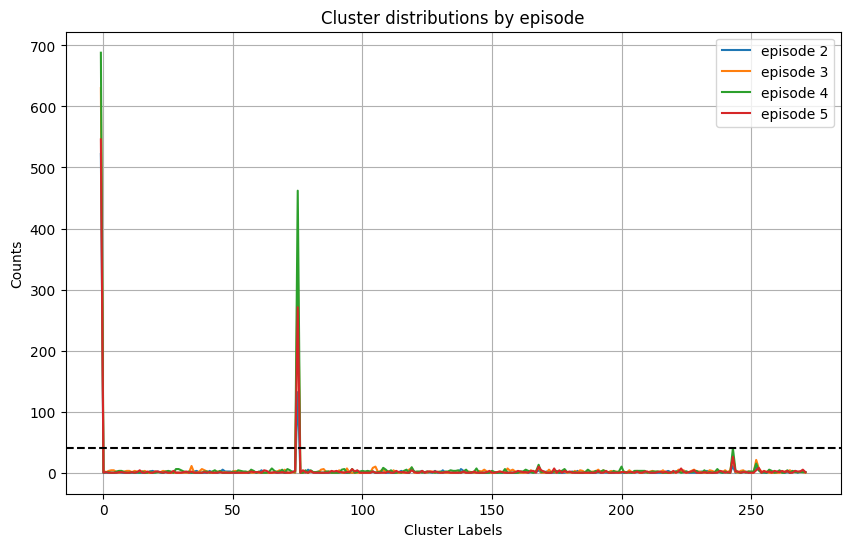

In [99]:
cc = cluster_eval(TFIDFword_clusters['2'])

In [103]:
cluster_explainer(TFIDFword_clusters['2'],TrainDF,[-1, 75, 243, 252],3)

cluster text example
======= ============
-1       So now instead of 18 months of development to make pong, we can do it in a week or two. Those are different sodium that you throw into the water is a chunk of metal and that's an oxidation state of zero. No, it's our problem and we need to bring in the people to work together to be able to figure out the best way to actually get to the result we wanna get to.
75       Yeah, yeah. Right. From them.
243       Was That's right. That's just It's
252       Exactly. Yeah, exactly. Exactly.


There are 4 groups with counts greater than 40. They are:
Int64Index([-1, 9, 17, 22], dtype='int64', name='7')


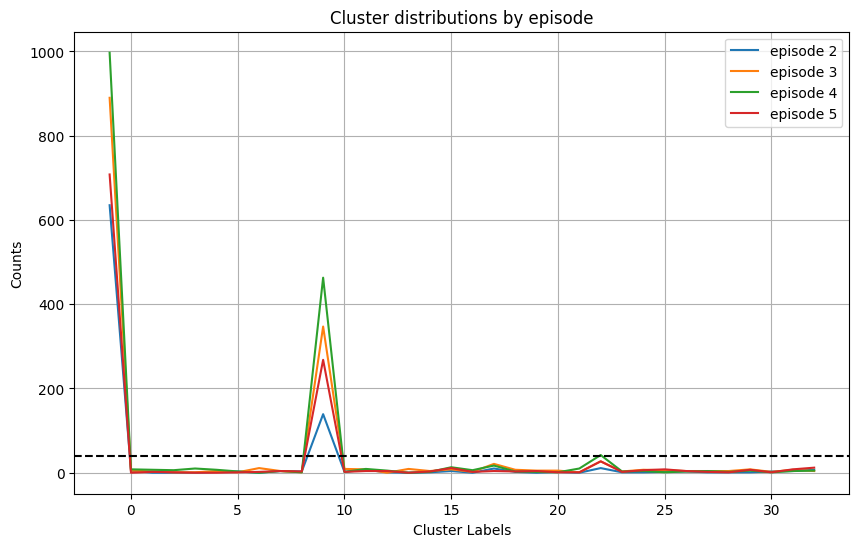

In [101]:
cc = cluster_eval(TFIDFword_clusters['7'])

In [104]:
cluster_explainer(TFIDFword_clusters['7'],TrainDF,[-1, 9, 17, 22],3)

cluster text example
======= ============
-1       And then water has one oxygen and two hydrogens. If one electron goes forward in time and then reverses going backwards in time and it just keeps doing that, then wherever you are in time, you'll see this record of electrons moving forward and backward in time in the instant that you make the observation. That's a question that that seems to upset a lot of people because we actually have done that work in depth.
9       How? Right. It
17       Yeah, exactly. Exactly. Exactly.
22       That's a thing. That's It's


#### n-grams

In [105]:
TFIDFngram_clusters = pd.DataFrame()

In [106]:
%%time
TFIDFngram_mod2, TFIDFngram_clusters['2'] = hdbscanner(Xng,2)
TFIDFngram_mod3, TFIDFngram_clusters['3'] = hdbscanner(Xng,3)
TFIDFngram_mod4, TFIDFngram_clusters['4'] = hdbscanner(Xng,4)
TFIDFngram_mod5, TFIDFngram_clusters['5'] = hdbscanner(Xng,5)
TFIDFngram_mod6, TFIDFngram_clusters['6'] = hdbscanner(Xng,6)
TFIDFngram_mod7, TFIDFngram_clusters['7'] = hdbscanner(Xng,7)
TFIDFngram_mod8, TFIDFngram_clusters['8'] = hdbscanner(Xng,8)
TFIDFngram_mod9, TFIDFngram_clusters['9'] = hdbscanner(Xng,9)
TFIDFngram_mod10, TFIDFngram_clusters['10'] = hdbscanner(Xng,10)

min_size:2 unclustered:2495  number of labels:212
min_size:3 unclustered:2885  number of labels:87
min_size:4 unclustered:3001  number of labels:53
min_size:5 unclustered:3063  number of labels:35
min_size:6 unclustered:3150  number of labels:27
min_size:7 unclustered:3180  number of labels:22
min_size:8 unclustered:3156  number of labels:19
min_size:9 unclustered:3220  number of labels:12
min_size:10 unclustered:3192  number of labels:10
CPU times: user 46min 17s, sys: 19.8 s, total: 46min 37s
Wall time: 46min 36s


There are 2 groups with counts greater than 40. They are:
Int64Index([-1, 209], dtype='int64', name='2')


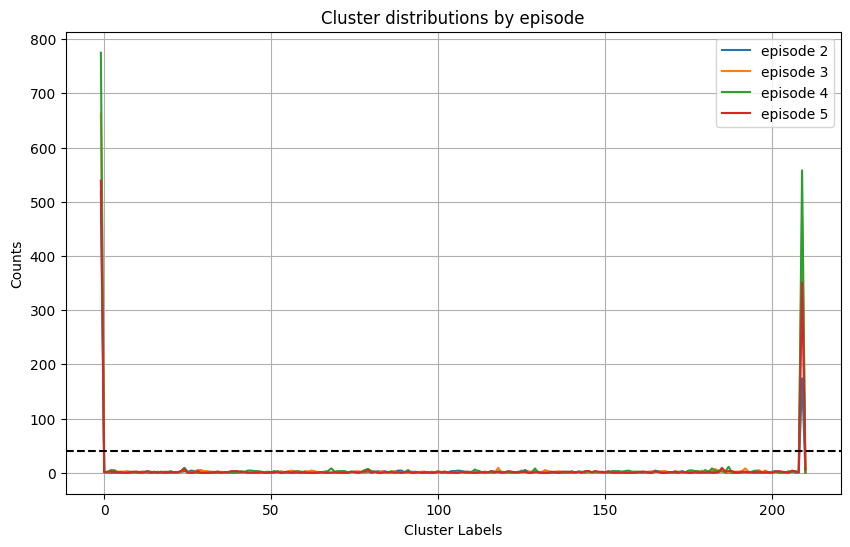

In [108]:
cc = cluster_eval(TFIDFngram_clusters['2'])

In [109]:
cluster_explainer(TFIDFngram_clusters['2'],TrainDF,[-1, 9, 17, 22],3)

cluster text example
======= ============
-1       For those of you who don't know Joel God ISS wine. It's, it's a fun thing to think about. Somebody from the beehive bus
9       Wait, wait, wait, wait. Wait, wait, wait, wait. Wait, wait, wait.
17       That sounds crazy. That sounds good. That sounds insane.
22       As as in the public station model. Are we in the weeds with tomato and tomato? All in the timing.


There are 2 groups with counts greater than 40. They are:
Int64Index([-1, 50], dtype='int64', name='4')


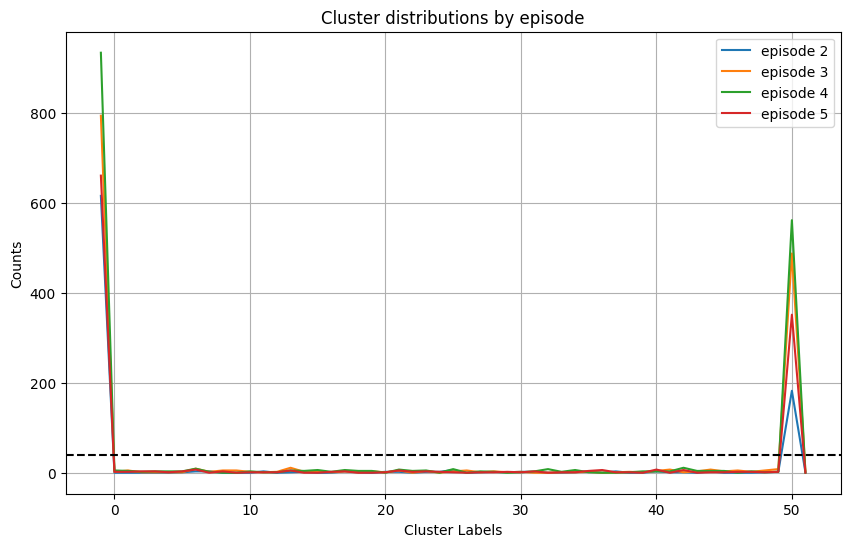

In [110]:
cc = cluster_eval(TFIDFngram_clusters['4'])

In [111]:
cluster_explainer(TFIDFngram_clusters['4'],TrainDF,[-1, 9, 17, 22],3)

cluster text example
======= ============
-1       Give the chuck so he can mangle it. Or he say that something, I think it is You know did. And it's that imbalance
9       That's good. That's good That's good.
17       You know, invented fields. I mean CPUs and GPUs. You know.
22       Let's make some shit up. Let's Let's, let's go with Isaac Kinsey.


### DBScan on Counts Vectors

In [160]:
Counts_clusters = pd.DataFrame()

In [161]:
%%time
Counts_mod2, Counts_clusters['2'] = hdbscanner(TrainDF_count,2)
Counts_mod3, Counts_clusters['3'] = hdbscanner(TrainDF_count,3)
Counts_mod4, Counts_clusters['4'] = hdbscanner(TrainDF_count,4)
Counts_mod5, Counts_clusters['5'] = hdbscanner(TrainDF_count,5)
Counts_mod6, Counts_clusters['6'] = hdbscanner(TrainDF_count,6)
Counts_mod7, Counts_clusters['7'] = hdbscanner(TrainDF_count,7)
Counts_mod8, Counts_clusters['8'] = hdbscanner(TrainDF_count,8)
Counts_mod9, Counts_clusters['9'] = hdbscanner(TrainDF_count,9)
Counts_mod10, Counts_clusters['10'] = hdbscanner(TrainDF_count,10)

min_size:2 unclustered:3507  number of labels:144
min_size:3 unclustered:3618  number of labels:83
min_size:4 unclustered:3667  number of labels:59
min_size:5 unclustered:3712  number of labels:47
min_size:6 unclustered:3660  number of labels:36
min_size:7 unclustered:3866  number of labels:29
min_size:8 unclustered:3893  number of labels:24
min_size:9 unclustered:3926  number of labels:17
min_size:10 unclustered:3947  number of labels:18
CPU times: user 36min 7s, sys: 18.6 s, total: 36min 25s
Wall time: 36min 27s


There are 5 groups with counts greater than 40. They are:
Int64Index([-1, 77, 90, 108, 128], dtype='int64', name='2')


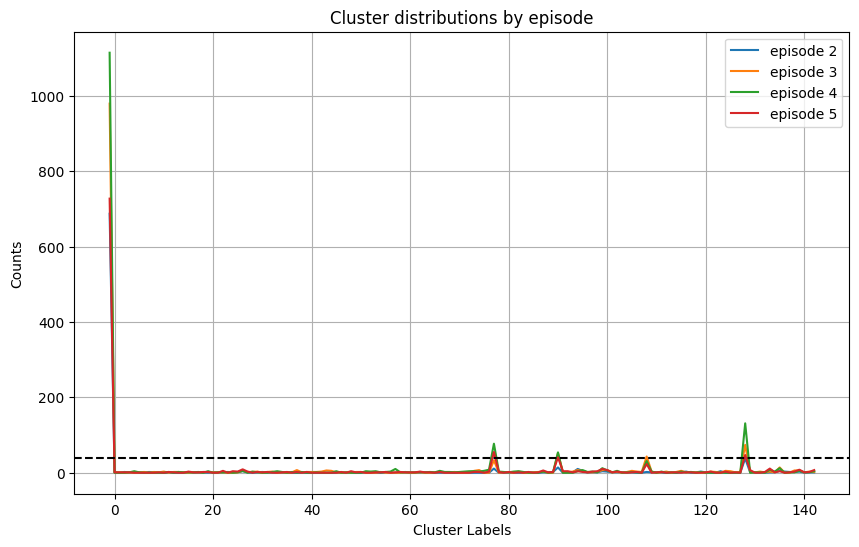

In [162]:
cc = cluster_eval(Counts_clusters['2'])

In [163]:
cluster_explainer(Counts_clusters['2'],TrainDF,[-1, 77, 90, 108, 128],3)

cluster text example
======= ============
-1       Which I will paraphrase saying yesterday is history. Yes, that's That's amazing.
77       Right. Right. S, right?
90       Okay. Okay. Okay.
108       Yes. Yes. Yes.
128       Yeah. Yeah. Yeah.


There are 6 groups with counts greater than 40. They are:
Int64Index([-1, 6, 13, 15, 29, 33], dtype='int64', name='6')


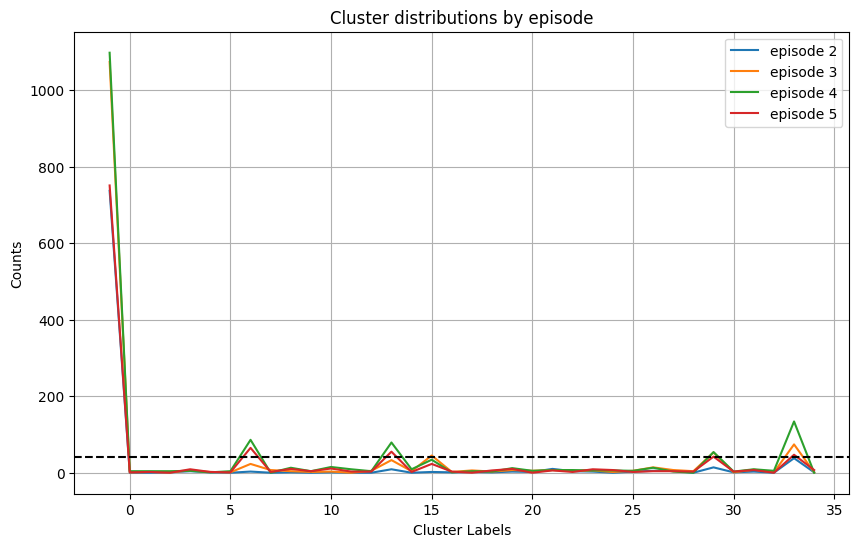

In [164]:
cc = cluster_eval(Counts_clusters['6'])

In [165]:
cluster_explainer(Counts_clusters['3'],TrainDF,[-1, 6, 13, 15, 29, 33],3)

cluster text example
======= ============
-1       To give because it plus and a minus. Again, we, we would almost certainly think so based on just what we've done from say, human versus ai, which people or ML machine learning that people have looked at, right? so it acts like a lab coat.
6       Nice. Nice, nice. Nice.
13       Neil. Hey, Neil. Hi, Neil.
15       Sorry. Sorry. Sorry,
29       True. Also true. True.
33       There. Right there. There.


### DBScan on Word embedding

#### 6-word window

In [183]:
word6embed_clusters = pd.DataFrame()

In [184]:
%%time
word6embed_mod2, word6embed_clusters['2'] = hdbscanner(document_vectors,2)
word6embed_mod3, word6embed_clusters['3'] = hdbscanner(document_vectors,3)
word6embed_mod4, word6embed_clusters['4'] = hdbscanner(document_vectors,4)
word6embed_mod5, word6embed_clusters['5'] = hdbscanner(document_vectors,5)
word6embed_mod6, word6embed_clusters['6'] = hdbscanner(document_vectors,6)
word6embed_mod7, word6embed_clusters['7'] = hdbscanner(document_vectors,7)
word6embed_mod8, word6embed_clusters['8'] = hdbscanner(document_vectors,8)
word6embed_mod9, word6embed_clusters['9'] = hdbscanner(document_vectors,9)
word6embed_mod10, word6embed_clusters['10'] = hdbscanner(document_vectors,10)

min_size:2 unclustered:2375  number of labels:259
min_size:3 unclustered:2542  number of labels:128
min_size:4 unclustered:1758  number of labels:85
min_size:5 unclustered:2184  number of labels:65
min_size:6 unclustered:2301  number of labels:54
min_size:7 unclustered:2123  number of labels:50
min_size:8 unclustered:2181  number of labels:45
min_size:9 unclustered:2232  number of labels:38
min_size:10 unclustered:1768  number of labels:31
CPU times: user 22.4 s, sys: 201 ms, total: 22.6 s
Wall time: 22.6 s


There are 7 groups with counts greater than 40. They are:
Int64Index([-1, 13, 29, 30, 38, 58, 82], dtype='int64', name='4')


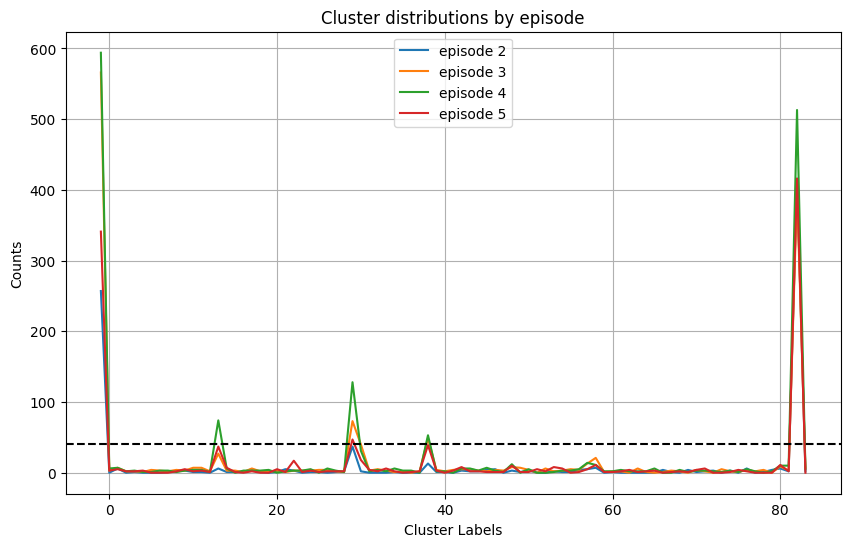

In [185]:
cc = cluster_eval(word6embed_clusters['4'])

In [186]:
cluster_explainer(word6embed_clusters['4'],TrainDF,[-1, 13, 29, 30, 38, 58, 82],3)

cluster text example
======= ============
-1       Insane. We That's, that's the point.
13       Right. Right. Right.
29       Yeah. Yeah. Yeah.
30       Yes. Yes. Yes.
38       Okay. Okay. Okay.
58       They typically have short lifetimes. Verage, follower and ho Yeah. Said futon kind, kind of flying sofa bed.
82       Well, Brad, any future thoughts so that we can think nice things about your work instead of worry about how one day will become our overlord. You have this ground truth that using this hardware, this wetware it is possible to have these effects. He says, I would love to know what the both doctors think is the greatest achievement in astrophysics of all time.


There are 8 groups with counts greater than 40. They are:
Int64Index([-1, 7, 17, 18, 22, 30, 31, 46], dtype='int64', name='7')


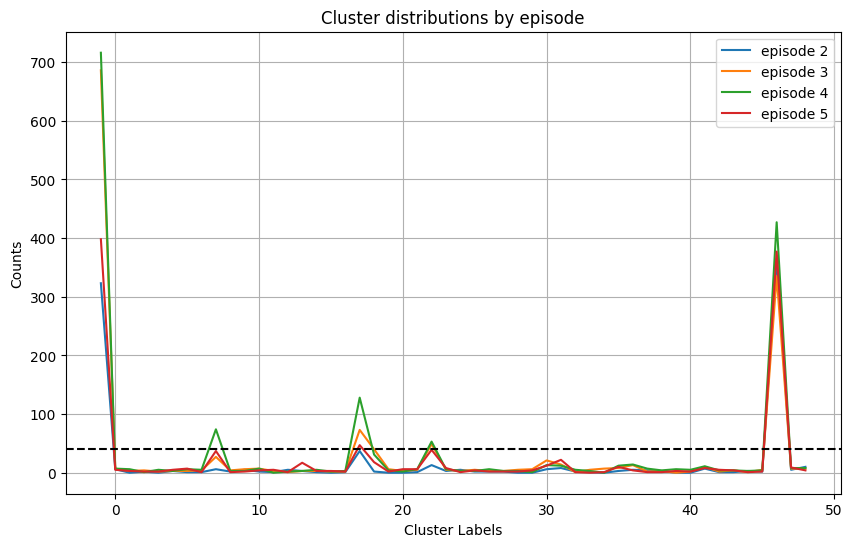

In [187]:
cc = cluster_eval(word6embed_clusters['7'])

In [188]:
cluster_explainer(word6embed_clusters['7'],TrainDF,[-1, 7, 17, 18, 22, 30, 31, 46],3)

cluster text example
======= ============
-1       I wanna know how long my reaction's gonna take. I Oh my God.
7       Right. Right. Right.
17       Yeah. Yeah. Yeah.
18       Yes. Yes. Yes.
22       Okay. Okay. Okay.
30       'cause I'd be too distracted listening to his story. Sometimes yes, sometimes no. And Lawrence says, good day gentlemen and gentle lady.
31       Yep. Calculator. Hmm.
46       What happens if a computer is made of the building? Well, the, the colors are red, green, and blue. Why can't you just nudge the photon to go a little faster?


There are 9 groups with counts greater than 40. They are:
Int64Index([-1, 6, 12, 13, 17, 19, 21, 22, 28], dtype='int64', name='10')


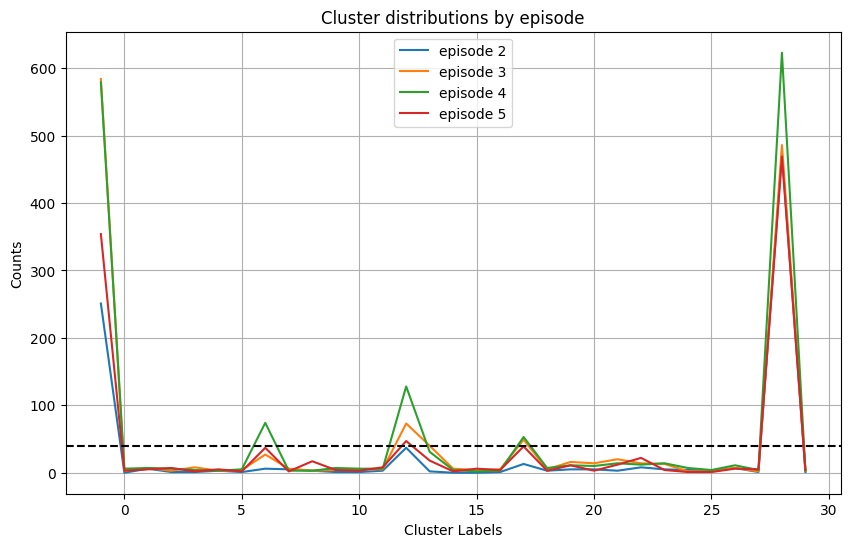

In [189]:
cc = cluster_eval(word6embed_clusters['10'])

In [190]:
cluster_explainer(word6embed_clusters['10'],TrainDF,[-1, 6, 12, 13, 17, 19, 21, 22, 28],3)

cluster text example
======= ============
-1       Sometimes yes, sometimes no. That's weird. It's a Cosmic Queries.
6       Right. Right. Right.
12       Yeah. Yeah. Yeah.
13       Yes. Yes. Yes.
17       Okay. Okay. Okay.
19       Said futon kind, kind of flying sofa bed. Start talk always good, Chuck. Verage, follower and ho Yeah.
21       Wow. Anywhere. Dorf.
22       Apologies. Woohoo. 72.
28       One is, well the human brain's the most capable brain for doing complex tasks that we know of. There's a negative sign where X, Y, and Z have a positive sign. Thought you said futons there for a second.


#### 3-word window

In [191]:
word3embed_clusters = pd.DataFrame()

In [192]:
%%time
word3embed_mod2, word3embed_clusters['2'] = hdbscanner(document_vectors2,2)
word3embed_mod3, word3embed_clusters['3'] = hdbscanner(document_vectors2,3)
word3embed_mod4, word3embed_clusters['4'] = hdbscanner(document_vectors2,4)
word3embed_mod5, word3embed_clusters['5'] = hdbscanner(document_vectors2,5)
word3embed_mod6, word3embed_clusters['6'] = hdbscanner(document_vectors2,6)
word3embed_mod7, word3embed_clusters['7'] = hdbscanner(document_vectors2,7)
word3embed_mod8, word3embed_clusters['8'] = hdbscanner(document_vectors2,8)
word3embed_mod9, word3embed_clusters['9'] = hdbscanner(document_vectors2,9)
word3embed_mod10, word3embed_clusters['10'] = hdbscanner(document_vectors2,10)

min_size:2 unclustered:2580  number of labels:280
min_size:3 unclustered:2556  number of labels:121
min_size:4 unclustered:1820  number of labels:72
min_size:5 unclustered:1987  number of labels:60
min_size:6 unclustered:2056  number of labels:50
min_size:7 unclustered:1447  number of labels:43
min_size:8 unclustered:2107  number of labels:43
min_size:9 unclustered:1930  number of labels:35
min_size:10 unclustered:2017  number of labels:33
CPU times: user 23.9 s, sys: 217 ms, total: 24.1 s
Wall time: 24.2 s


There are 8 groups with counts greater than 40. They are:
Int64Index([-1, 16, 20, 34, 35, 42, 60, 69], dtype='int64', name='4')


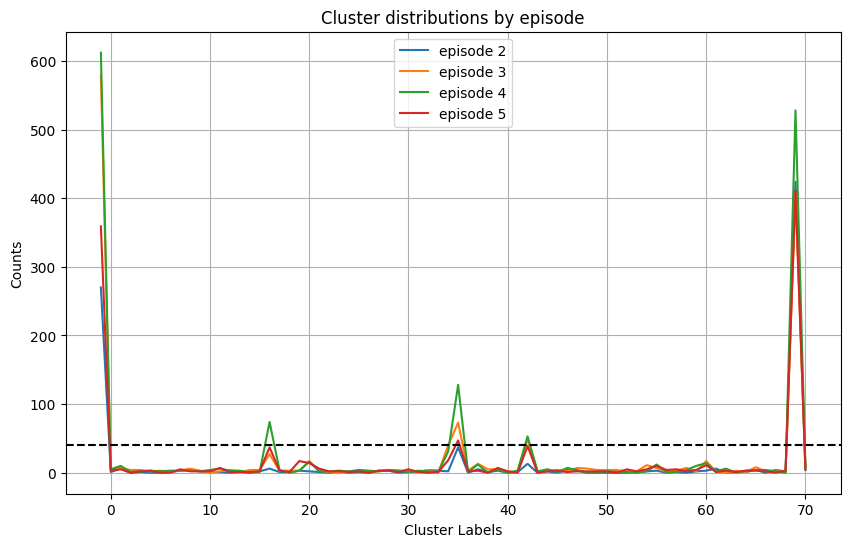

In [193]:
cc = cluster_eval(word3embed_clusters['4'])

In [194]:
cluster_explainer(word3embed_clusters['4'],TrainDF,[-1, 16, 20, 34, 35, 42, 60, 69],3)

cluster text example
======= ============
-1       Don't leave me check. Do molecules have like docking ports basically? Yes, I did.
16       Right. Right. Right.
20       Magnetic fields. Above 72. Electric passes straight through.
34       Yes. Yes. Yes.
35       Yeah. Yeah. Yeah.
42       Okay. Okay. Okay.
60       The right hand column personified by chuck. The alter ego of his fan club. Little neutron.
69       What happens if a computer is made of the building? In fact, this idea of entanglement and wormholes suggest that gravity quantum, they're already Where did these come from?


There are 8 groups with counts greater than 40. They are:
Int64Index([-1, 10, 22, 23, 24, 28, 31, 40], dtype='int64', name='7')


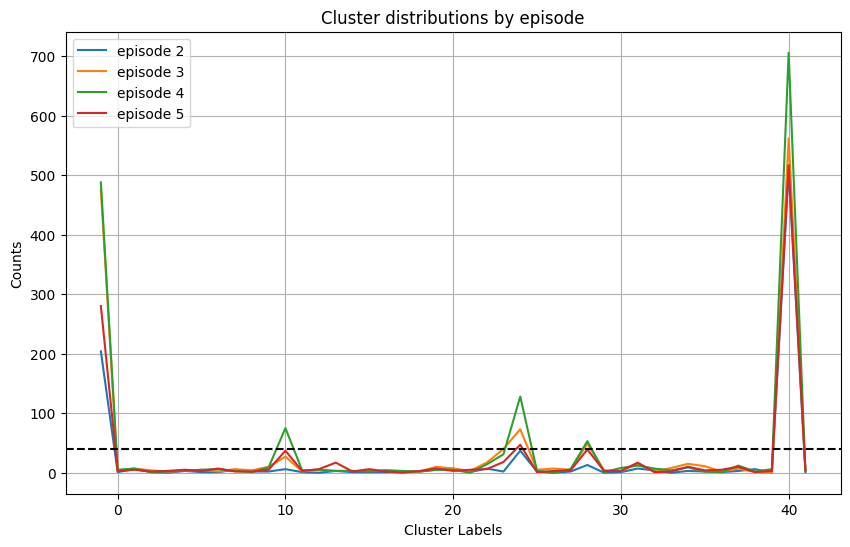

In [195]:
cc = cluster_eval(word3embed_clusters['7'])

In [196]:
cluster_explainer(word3embed_clusters['7'],TrainDF,[-1, 10, 22, 23, 24, 28, 31, 40],3)

cluster text example
======= ============
-1       That is cool man. What we'd like to think though, that Lord Nice.
10       Right. Right. Right.
22       Exactly. Sure. Exactly.
23       Yes. Yes. Yes.
24       Yeah. Yeah. Yeah.
28       Okay. Okay. Okay.
31       Boom. Hmm. Harmony.
40       You have a cork pair. The equation's all blow up. We call them scientists, those who never lost that childhood curiosity.


There are 9 groups with counts greater than 40. They are:
Int64Index([-1, 8, 15, 16, 17, 22, 24, 26, 32], dtype='int64', name='9')


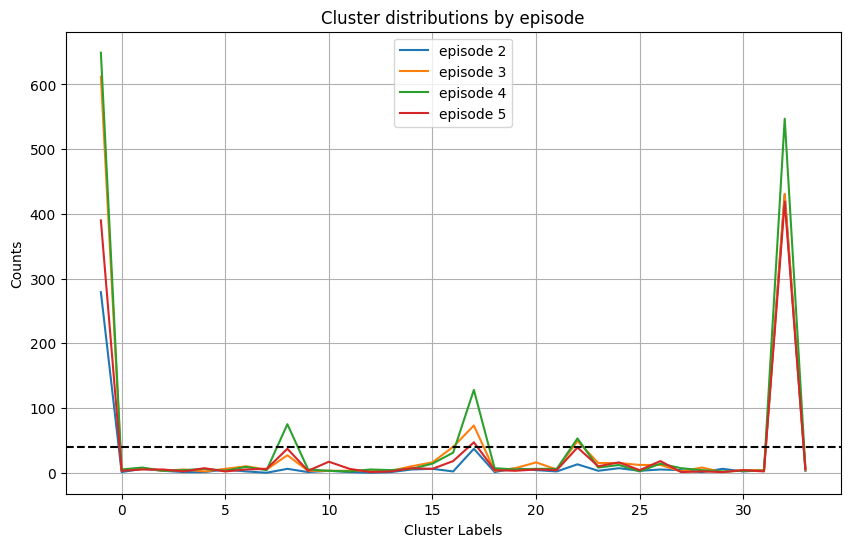

In [197]:
cc = cluster_eval(word3embed_clusters['9'])

In [198]:
cluster_explainer(word3embed_clusters['9'],TrainDF,[-1, 8, 15, 16, 17, 22, 24, 26, 32],3)

cluster text example
======= ============
-1       And there At one atmosphere. And that's gonna come with certain benefits and certain risks.
8       Right. Right. Right.
15       Exactly. Sure. Exactly.
16       Yes. Yes. Yes.
17       Yeah. Yeah. Yeah.
22       Okay. Okay. Okay.
24       Mm. Harmony. Hmm.
26       Indeed. Wow. Wow.
32       No, it's something you're not going to attempt. And it blew my fricking mind. That's how long ago it was.


## Application of fitted cluster models to labelled episode vector sets

### Parts of Speech

In [151]:
ep1_pos_clusters = pd.DataFrame()
pos_strengths = pd.DataFrame()

In [152]:
%%time
ep1_pos_clusters['2'], pos_strengths['2'] = hdbscan.approximate_predict(pos_mod2, ep1posDF)
ep1_pos_clusters['3'], pos_strengths['3'] = hdbscan.approximate_predict(pos_mod3, ep1posDF)
ep1_pos_clusters['4'], pos_strengths['4'] = hdbscan.approximate_predict(pos_mod4, ep1posDF)
ep1_pos_clusters['5'], pos_strengths['5'] = hdbscan.approximate_predict(pos_mod5, ep1posDF)
ep1_pos_clusters['6'], pos_strengths['6'] = hdbscan.approximate_predict(pos_mod6, ep1posDF)
ep1_pos_clusters['7'], pos_strengths['7'] = hdbscan.approximate_predict(pos_mod7, ep1posDF)
ep1_pos_clusters['8'], pos_strengths['8'] = hdbscan.approximate_predict(pos_mod8, ep1posDF)
ep1_pos_clusters['9'], pos_strengths['9'] = hdbscan.approximate_predict(pos_mod9, ep1posDF)
ep1_pos_clusters['10'], pos_strengths['10'] = hdbscan.approximate_predict(pos_mod10, ep1posDF)

CPU times: user 1.93 s, sys: 17.4 ms, total: 1.94 s
Wall time: 1.96 s


### TFIDF: words

In [153]:
ep1_TFIDFword_clusters = pd.DataFrame()
TFIDFword_strengths = pd.DataFrame()

In [157]:
%%time
ep1_TFIDFword_clusters['2'], TFIDFword_strengths['2'] = hdbscan.approximate_predict(TFIDFword_mod2, ep1_X.toarray())
ep1_TFIDFword_clusters['3'], TFIDFword_strengths['3'] = hdbscan.approximate_predict(TFIDFword_mod3, ep1_X.toarray())
ep1_TFIDFword_clusters['4'], TFIDFword_strengths['4'] = hdbscan.approximate_predict(TFIDFword_mod4, ep1_X.toarray())
ep1_TFIDFword_clusters['5'], TFIDFword_strengths['5'] = hdbscan.approximate_predict(TFIDFword_mod5, ep1_X.toarray())
ep1_TFIDFword_clusters['6'], TFIDFword_strengths['6'] = hdbscan.approximate_predict(TFIDFword_mod6, ep1_X.toarray())
ep1_TFIDFword_clusters['7'], TFIDFword_strengths['7'] = hdbscan.approximate_predict(TFIDFword_mod7, ep1_X.toarray())
ep1_TFIDFword_clusters['8'], TFIDFword_strengths['8'] = hdbscan.approximate_predict(TFIDFword_mod8, ep1_X.toarray())
ep1_TFIDFword_clusters['9'], TFIDFword_strengths['9'] = hdbscan.approximate_predict(TFIDFword_mod9, ep1_X.toarray())
ep1_TFIDFword_clusters['10'], TFIDFword_strengths['10'] = hdbscan.approximate_predict(TFIDFword_mod10, ep1_X.toarray())

CPU times: user 4min 34s, sys: 2.27 s, total: 4min 36s
Wall time: 4min 38s


### TFIDF: n-grams

In [158]:
ep1_TFIDFngram_clusters = pd.DataFrame()
TFIDFngram_strengths = pd.DataFrame()

In [159]:
%%time
ep1_TFIDFngram_clusters['2'], TFIDFngram_strengths['2'] = hdbscan.approximate_predict(TFIDFngram_mod2, ep1_Xng.toarray())
ep1_TFIDFngram_clusters['3'], TFIDFngram_strengths['3'] = hdbscan.approximate_predict(TFIDFngram_mod3, ep1_Xng.toarray())
ep1_TFIDFngram_clusters['4'], TFIDFngram_strengths['4'] = hdbscan.approximate_predict(TFIDFngram_mod4, ep1_Xng.toarray())
ep1_TFIDFngram_clusters['5'], TFIDFngram_strengths['5'] = hdbscan.approximate_predict(TFIDFngram_mod5, ep1_Xng.toarray())
ep1_TFIDFngram_clusters['6'], TFIDFngram_strengths['6'] = hdbscan.approximate_predict(TFIDFngram_mod6, ep1_Xng.toarray())
ep1_TFIDFngram_clusters['7'], TFIDFngram_strengths['7'] = hdbscan.approximate_predict(TFIDFngram_mod7, ep1_Xng.toarray())
ep1_TFIDFngram_clusters['8'], TFIDFngram_strengths['8'] = hdbscan.approximate_predict(TFIDFngram_mod8, ep1_Xng.toarray())
ep1_TFIDFngram_clusters['9'], TFIDFngram_strengths['9'] = hdbscan.approximate_predict(TFIDFngram_mod9, ep1_Xng.toarray())
ep1_TFIDFngram_clusters['10'], TFIDFngram_strengths['10'] = hdbscan.approximate_predict(TFIDFngram_mod10, ep1_Xng.toarray())

CPU times: user 6min 35s, sys: 2.69 s, total: 6min 38s
Wall time: 6min 40s


### Count vectors

In [166]:
ep1_Count_clusters = pd.DataFrame()
Count_strengths = pd.DataFrame()

In [168]:
%%time
ep1_Count_clusters['2'], Count_strengths['2'] = hdbscan.approximate_predict(Counts_mod2, ep1_count.toarray())
ep1_Count_clusters['3'], Count_strengths['3'] = hdbscan.approximate_predict(Counts_mod3, ep1_count.toarray())
ep1_Count_clusters['4'], Count_strengths['4'] = hdbscan.approximate_predict(Counts_mod4, ep1_count.toarray())
ep1_Count_clusters['5'], Count_strengths['5'] = hdbscan.approximate_predict(Counts_mod5, ep1_count.toarray())
ep1_Count_clusters['6'], Count_strengths['6'] = hdbscan.approximate_predict(Counts_mod6, ep1_count.toarray())
ep1_Count_clusters['7'], Count_strengths['7'] = hdbscan.approximate_predict(Counts_mod7, ep1_count.toarray())
ep1_Count_clusters['8'], Count_strengths['8'] = hdbscan.approximate_predict(Counts_mod8, ep1_count.toarray())
ep1_Count_clusters['9'], Count_strengths['9'] = hdbscan.approximate_predict(Counts_mod9, ep1_count.toarray())
ep1_Count_clusters['10'], Count_strengths['10'] = hdbscan.approximate_predict(Counts_mod10, ep1_count.toarray())

CPU times: user 4min 54s, sys: 1.36 s, total: 4min 56s
Wall time: 4min 57s


### Word Embedding: 6-term window 

In [199]:
ep1_word6embed_clusters = pd.DataFrame()
word6embed_strengths = pd.DataFrame()

In [200]:
%%time
ep1_word6embed_clusters['2'], word6embed_strengths['2'] = hdbscan.approximate_predict(word6embed_mod2, ep1_doc_vecs)
ep1_word6embed_clusters['3'], word6embed_strengths['3'] = hdbscan.approximate_predict(word6embed_mod3, ep1_doc_vecs)
ep1_word6embed_clusters['4'], word6embed_strengths['4'] = hdbscan.approximate_predict(word6embed_mod4, ep1_doc_vecs)
ep1_word6embed_clusters['5'], word6embed_strengths['5'] = hdbscan.approximate_predict(word6embed_mod5, ep1_doc_vecs)
ep1_word6embed_clusters['6'], word6embed_strengths['6'] = hdbscan.approximate_predict(word6embed_mod6, ep1_doc_vecs)
ep1_word6embed_clusters['7'], word6embed_strengths['7'] = hdbscan.approximate_predict(word6embed_mod7, ep1_doc_vecs)
ep1_word6embed_clusters['8'], word6embed_strengths['8'] = hdbscan.approximate_predict(word6embed_mod8, ep1_doc_vecs)
ep1_word6embed_clusters['9'], word6embed_strengths['9'] = hdbscan.approximate_predict(word6embed_mod9, ep1_doc_vecs)
ep1_word6embed_clusters['10'], word6embed_strengths['10'] = hdbscan.approximate_predict(word6embed_mod10, ep1_doc_vecs)

CPU times: user 3.69 s, sys: 25.1 ms, total: 3.72 s
Wall time: 3.73 s


### Word Embedding: 3-term window 

In [201]:
ep1_word3embed_clusters = pd.DataFrame()
word3embed_strengths = pd.DataFrame()

In [202]:
%%time
ep1_word3embed_clusters['2'], word3embed_strengths['2'] = hdbscan.approximate_predict(word3embed_mod2, ep1_doc_vecs2)
ep1_word3embed_clusters['3'], word3embed_strengths['3'] = hdbscan.approximate_predict(word3embed_mod3, ep1_doc_vecs2)
ep1_word3embed_clusters['4'], word3embed_strengths['4'] = hdbscan.approximate_predict(word3embed_mod4, ep1_doc_vecs2)
ep1_word3embed_clusters['5'], word3embed_strengths['5'] = hdbscan.approximate_predict(word3embed_mod5, ep1_doc_vecs2)
ep1_word3embed_clusters['6'], word3embed_strengths['6'] = hdbscan.approximate_predict(word3embed_mod6, ep1_doc_vecs2)
ep1_word3embed_clusters['7'], word3embed_strengths['7'] = hdbscan.approximate_predict(word3embed_mod7, ep1_doc_vecs2)
ep1_word3embed_clusters['8'], word3embed_strengths['8'] = hdbscan.approximate_predict(word3embed_mod8, ep1_doc_vecs2)
ep1_word3embed_clusters['9'], word3embed_strengths['9'] = hdbscan.approximate_predict(word3embed_mod9, ep1_doc_vecs2)
ep1_word3embed_clusters['10'], word3embed_strengths['10'] = hdbscan.approximate_predict(word3embed_mod10, ep1_doc_vecs2)

CPU times: user 3.98 s, sys: 22.4 ms, total: 4 s
Wall time: 4.02 s


## Cluster homogeneity

In [205]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import homogeneity_score
import heapq

In [141]:
X_train, X_test, y_train, y_test = train_test_split(ep1_labelled['Text'], ep1_labelled['Label'], test_size=0.2, stratify=ep1_labelled['Label'], random_state=94)

In [142]:
train_indices = X_train.index.tolist()
test_indices = X_test.index.tolist()

In [207]:
ms=['2','3','4','5','6','7','8','9','10']

In [211]:
#Function to test homogeneity of cluster models and return the 3 best models
def homogeneity_test(clusterDF,model_type,ms):
    scores=[]
    for m in ms:
        h_score = homogeneity_score(y_train[train_indices],clusterDF.loc[train_indices,m])
        scores.append(h_score)
    top3_ind_val = heapq.nlargest(3, enumerate(scores), key=lambda x: x[1])
    top3_ind = [index for index, value in top3_ind_val]
    top3_val = [value for index, value in top3_ind_val]
    plt.bar(ms, scores, color='skyblue')
    # Adding titles and labels
    plt.title(f"Homogeneity scores of HDBScan clustering on {model_type} vectors")
    plt.xlabel('Minimum Cluster Size')
    plt.ylabel('Homogeneity Score')
    plt.xticks(ms)
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Showing the plot
    plt.show()
    
    return [ms[i] for i in top3_ind],top3_val

### Parts of Speech

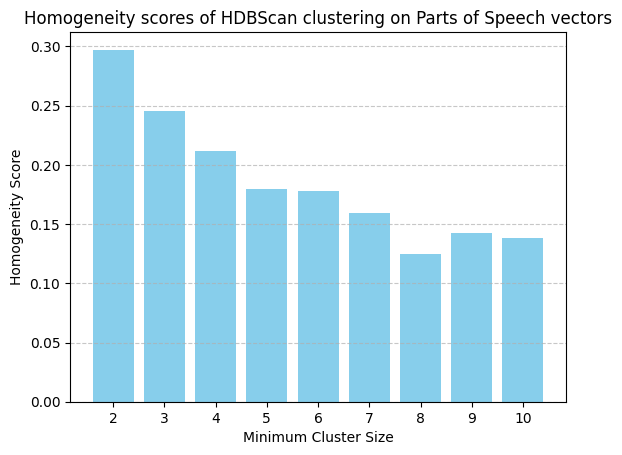

In [212]:
top3pos = homogeneity_test(ep1_pos_clusters,'Parts of Speech',ms)

### TFIDF: words

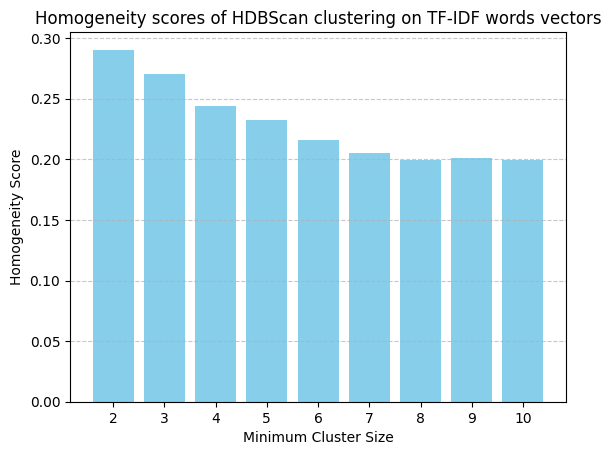

In [268]:
top3TFIDFword = homogeneity_test(ep1_TFIDFword_clusters,'TF-IDF words',ms)

### TFIDF: n-grams

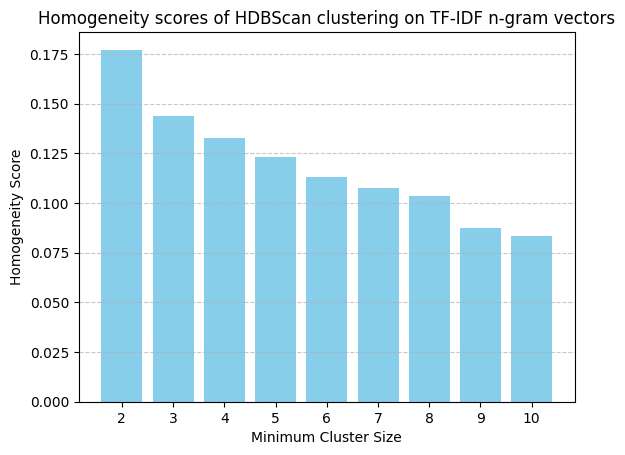

In [269]:
top3TFIDFngram = homogeneity_test(ep1_TFIDFngram_clusters,'TF-IDF n-gram',ms)

### Count vectors

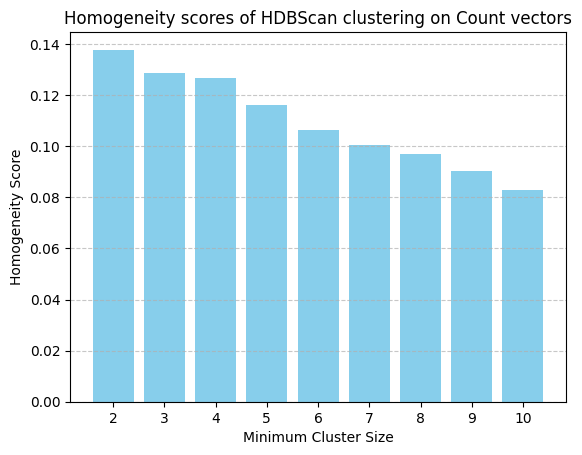

In [270]:
top3count = homogeneity_test(ep1_Count_clusters,'Count',ms)

### Word Embedding: 6-term window 

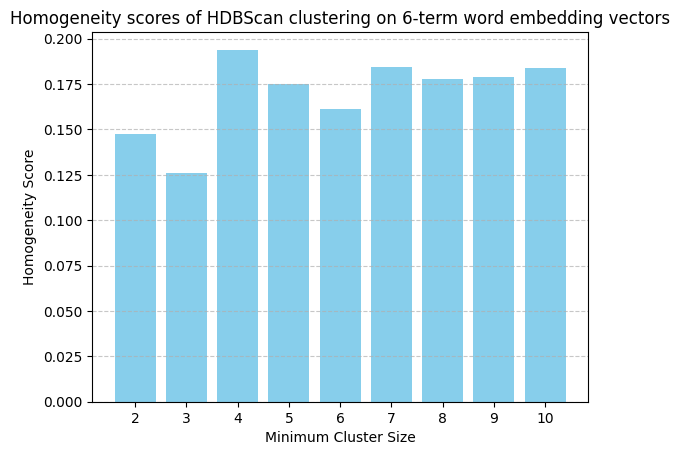

In [271]:
top3word6embed = homogeneity_test(ep1_word6embed_clusters,'6-term word embedding',ms)

### Word Embedding: 3-term window 

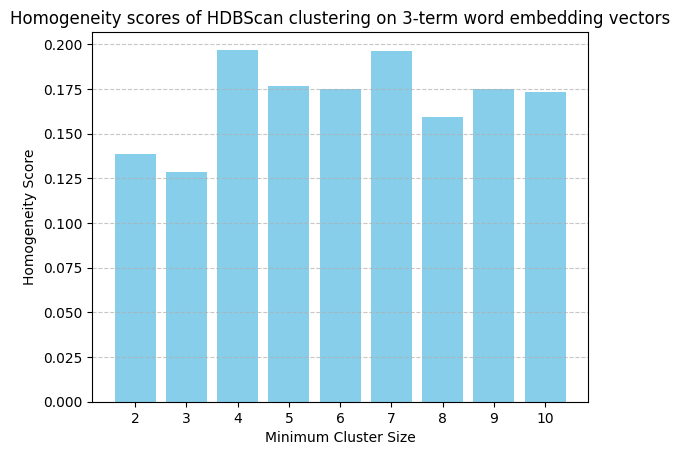

In [272]:
top3wordembed = homogeneity_test(ep1_word3embed_clusters,'3-term word embedding',ms)

### Top model homogeneity

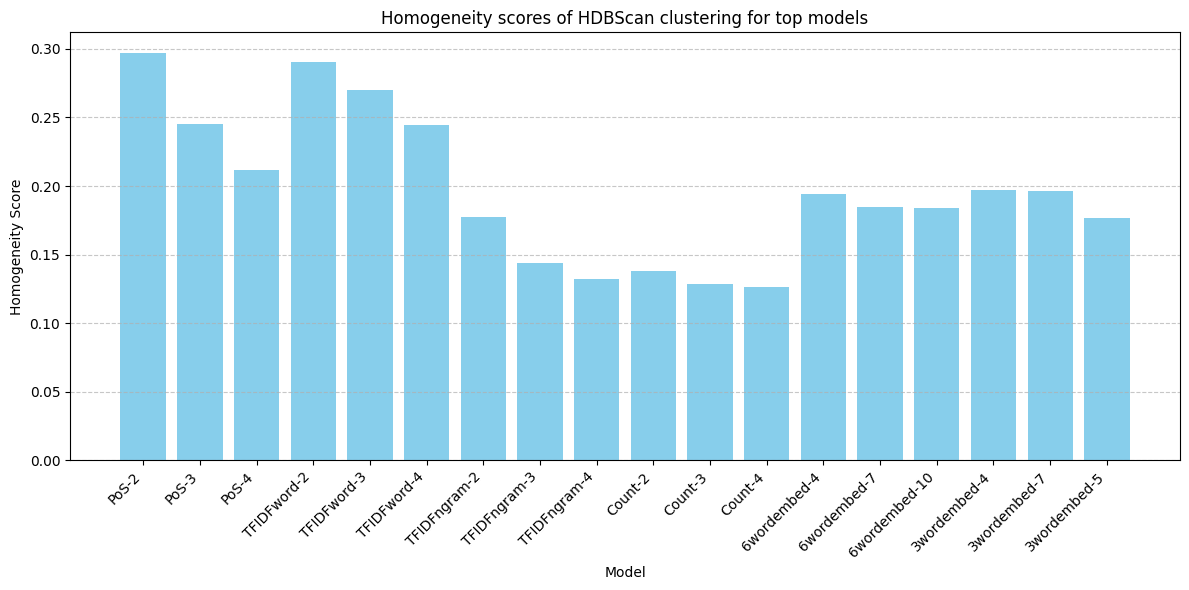

In [273]:
all_labels = []
all_vals = []
names = ["PoS-","TFIDFword-","TFIDFngram-","Count-","6wordembed-","3wordembed-"]
for var in [top3pos, top3TFIDFword, top3TFIDFngram, top3count, top3word6embed, top3wordembed]:
    all_labels.extend(lab for lab in var[0])
    all_vals.extend(val for val in var[1])
full_labs = [f"{names[i//3]}{all_labels[i]}" for i in range(len(all_labels))]
plt.figure(figsize=(12, 6))  # Adjust figure size as needed
plt.bar(full_labs, all_vals, color='skyblue')

# Adding titles and labels
plt.title(f"Homogeneity scores of HDBScan clustering for top models")
plt.xlabel('Model')
plt.ylabel('Homogeneity Score')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


### Training set mapping and evaluation

In [311]:
from sklearn.metrics import recall_score

In [274]:
def map_cluster_labels_to_binary(cluster_labels, binary_labels):
    # Combine cluster_labels and binary_labels into a DataFrame
    df = pd.DataFrame({'Cluster': cluster_labels, 'Binary': binary_labels})
    
    # Group by Cluster and calculate the majority vote for Binary label
    cluster_majority = df.groupby('Cluster')['Binary'].apply(lambda x: x.mode()[0]).reset_index()
    
    # Extract cluster labels where the majority binary outcome is 1
    clusters_with_binary_1 = cluster_majority[cluster_majority['Binary'] == 1]['Cluster'].tolist()
    
    return clusters_with_binary_1


In [275]:
def my_filter(cluster_labs, positive_labs):
    '''Takes the assigned cluster labels and if entries are in the list of positive labels, maps to 1
    otherwise mapping to 0 returning the binary classification predictions'''
    predicted_labels=[1 if lab in positive_labs else 0 for lab in cluster_labs]
    return predicted_labels

In [320]:

def map_acc(DF):
    maps=[]
    trainacc=[]
    trainrec=[]
    for col_name,col_data in DF.iteritems():
        map=map_cluster_labels_to_binary(col_data[train_indices],y_train[train_indices])
        maps.append(map)
        preds = my_filter(col_data[train_indices],map)
        acc = round(100*sum(preds==y_train)/len(train_indices),2)
        trainacc.append(acc)
        rec = round(recall_score(y_train, preds),2)
        trainrec.append(rec)
    return maps,trainacc,trainrec

In [321]:
maps1,trainacc1,trainrec1 = map_acc(ep1_pos_clusters)

In [322]:
maps2,trainacc2,trainrec2 = map_acc(ep1_TFIDFword_clusters)

In [323]:
maps3,trainacc3,trainrec3 = map_acc(ep1_TFIDFngram_clusters)

In [324]:
maps4,trainacc4,trainrec4 = map_acc(ep1_Count_clusters)

In [325]:
maps5,trainacc5,trainrec5 = map_acc(ep1_word6embed_clusters)

In [326]:
maps6,trainacc6,trainrec6 = map_acc(ep1_word3embed_clusters)

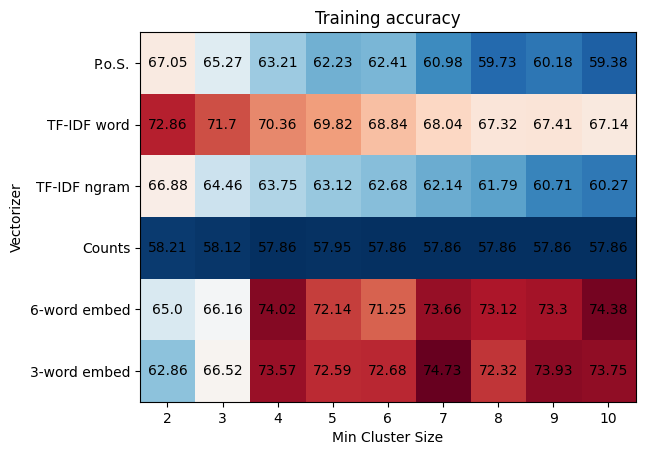

In [293]:
data = [trainacc1,trainacc2,trainacc3,trainacc4,trainacc5,trainacc6]
plt.imshow(data, cmap='RdBu_r', aspect='auto')
plt.xticks(np.arange(9), ['2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.yticks(np.arange(6), ['P.o.S.', 'TF-IDF word', 'TF-IDF ngram', 'Counts', '6-word embed', '3-word embed'])
plt.xlabel('Min Cluster Size')
plt.ylabel('Vectorizer')
for i in range(len(data)):
    for j in range(len(data[0])):
        plt.text(j, i, data[i][j], ha='center', va='center', color='black')
plt.title('Training accuracy')
plt.show()

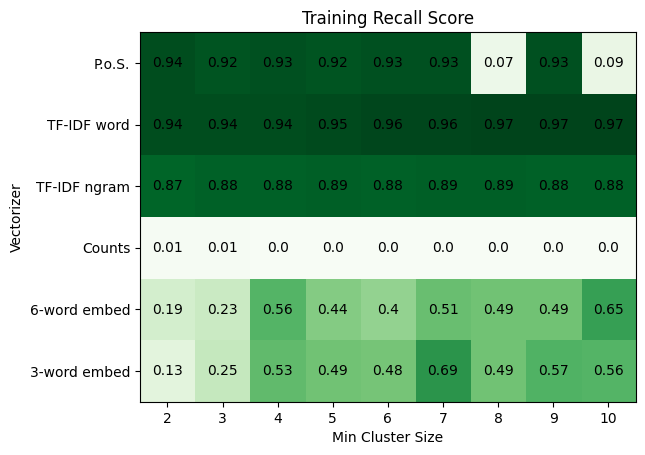

In [327]:
rdata = [trainrec1,trainrec2,trainrec3,trainrec4,trainrec5,trainrec6]
plt.imshow(rdata, cmap='Greens', aspect='auto')
plt.xticks(np.arange(9), ['2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.yticks(np.arange(6), ['P.o.S.', 'TF-IDF word', 'TF-IDF ngram', 'Counts', '6-word embed', '3-word embed'])
plt.xlabel('Min Cluster Size')
plt.ylabel('Vectorizer')
for i in range(len(rdata)):
    for j in range(len(rdata[0])):
        plt.text(j, i, rdata[i][j], ha='center', va='center', color='black')
plt.title('Training Recall Score')
plt.show()

### Testing set mapping

In [295]:
def predictor(DF,maps):
    preds=[]
    testacc=[]
    for i,(col_name,col_data) in enumerate(DF.iteritems()):
        pred = my_filter(col_data[test_indices],maps[i])
        preds.append(pred)
        acc = round(100*sum(pred==y_test)/len(test_indices),2)
        testacc.append(acc)
    return preds,testacc

In [296]:
preds1,testacc1 = predictor(ep1_pos_clusters,maps1)
preds2,testacc2 = predictor(ep1_TFIDFword_clusters,maps2)
preds3,testacc3 = predictor(ep1_TFIDFngram_clusters,maps3)
preds4,testacc4 = predictor(ep1_Count_clusters,maps4)
preds5,testacc5 = predictor(ep1_word6embed_clusters,maps5)
preds6,testacc6 = predictor(ep1_word3embed_clusters,maps6)

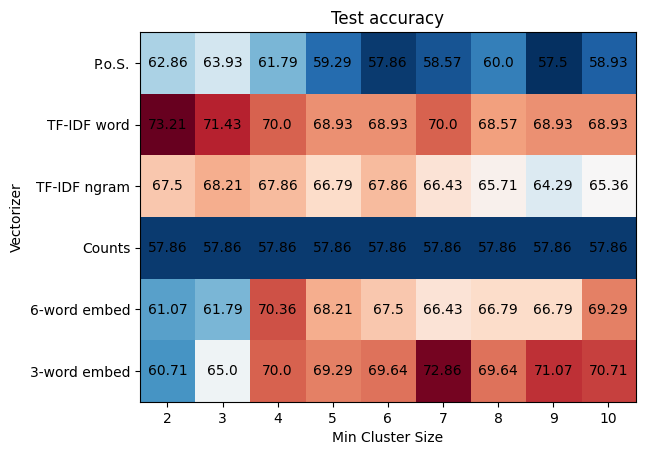

In [304]:
data1 = [testacc1,testacc2,testacc3,testacc4,testacc5,testacc6]
plt.imshow(data1, cmap='RdBu_r', aspect='auto')
plt.xticks(np.arange(9), ['2', '3', '4', '5', '6', '7', '8', '9', '10'])
plt.yticks(np.arange(6), ['P.o.S.', 'TF-IDF word', 'TF-IDF ngram', 'Counts', '6-word embed', '3-word embed'])
plt.xlabel('Min Cluster Size')
plt.ylabel('Vectorizer')
for i in range(len(data1)):
    for j in range(len(data1[0])):
        plt.text(j, i, data1[i][j], ha='center', va='center', color='black')
plt.title('Test accuracy')
plt.show()

## Filtered cluster comparisons with manual labelling

In [285]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import homogeneity_completeness_v_measure
import seaborn as sns

In [305]:
def reporter(manual, estimated,model_name):
    accuracy_ = accuracy_score(manual, estimated)
    precision_ = precision_score(manual, estimated)
    recall_ = recall_score(manual, estimated)
    rand_ = adjusted_rand_score(manual, estimated)
    homogeneity, completeness, v_measure = homogeneity_completeness_v_measure(manual, estimated)

    print('Accuracy    : %.4f Proportion of estimated labels that match the applied labels.               Best: 1, Worst: 0' % accuracy_)
    print('Precision   : %.4f Proportion of "relevant" predictions that are correctly matched.            Best: 1, Worst: 0' % precision_)
    print('Recall      : %.4f Proportion of correct "relevant" predictions from all "relevant" instances. Best: 1, Worst: 0' % recall_)
    print('ARI         : %.4f Similarity between class labels, 0 representing independence                Best: 1, Worst: -1' % rand_)
    print('Homogeneity : %.4f How well each predicted group matches with a single true class.             Best: 1, Worst: 0' % homogeneity)
    print('Completeness: %.4f How well all members of a true class are grouped in the predictions.        Best: 1, Worst: 0' % completeness)
    print('V-Measure   : %.4f How well predictions match applied labels.                                  Best: 1, Worst: 0' % v_measure)

    # Confusion Matrix
    mat = confusion_matrix(manual, estimated)

    # Precision/Recall
    prec, rec, _ = precision_recall_curve(manual, estimated)

    # plot
    fig, ax = plt.subplots(1, 2, figsize = (12, 6))
    fig.subplots_adjust(left = 0.02, right = 0.98, wspace = 0.2)

    # Confusion Matrix
    sns.heatmap(mat.T, square = True, annot = True, fmt = 'd', cbar = False, cmap = 'RdBu', ax = ax[0])

    ax[0].set_title(f"Confusion Matrix for {model_name}")
    ax[0].set_xlabel('Manually Applied label')
    ax[0].set_ylabel('Predicted label')

    # Precision/Recall
    step_kwargs = {'step': 'post'}
    ax[1].step(rec, prec, color = 'b', alpha = 0.2, where = 'post')
    ax[1].fill_between(rec, prec, alpha = 0.2, color = 'b', **step_kwargs)
    ax[1].set_ylim([0.0, 1.0])
    ax[1].set_xlim([0.0, 1.0])
    ax[1].set_xlabel('Recall')
    ax[1].set_ylabel('Precision')
    ax[1].set_title('2-class Precision-Recall curve')

    plt.show()
    data = {'Accuracy': accuracy_,
            'Precision': precision_,
            'Recall': recall_,
            'A.R.I.': rand_,
            'Homogeneity': homogeneity,
            'Completeness': completeness,
            'V-Measure': v_measure}
    report = pd.DataFrame.from_dict(data,orient='index',columns=[model_name])

    return report

### TF-IDF word: min cluster size 2

Accuracy    : 0.7321 Proportion of estimated labels that match the applied labels.               Best: 1, Worst: 0
Precision   : 0.6369 Proportion of "relevant" predictions that are correctly matched.            Best: 1, Worst: 0
Recall      : 0.8475 Proportion of correct "relevant" predictions from all "relevant" instances. Best: 1, Worst: 0
ARI         : 0.2126 Similarity between class labels, 0 representing independence                Best: 1, Worst: -1
Homogeneity : 0.1917 How well each predicted group matches with a single true class.             Best: 1, Worst: 0
Completeness: 0.1903 How well all members of a true class are grouped in the predictions.        Best: 1, Worst: 0
V-Measure   : 0.1910 How well predictions match applied labels.                                  Best: 1, Worst: 0


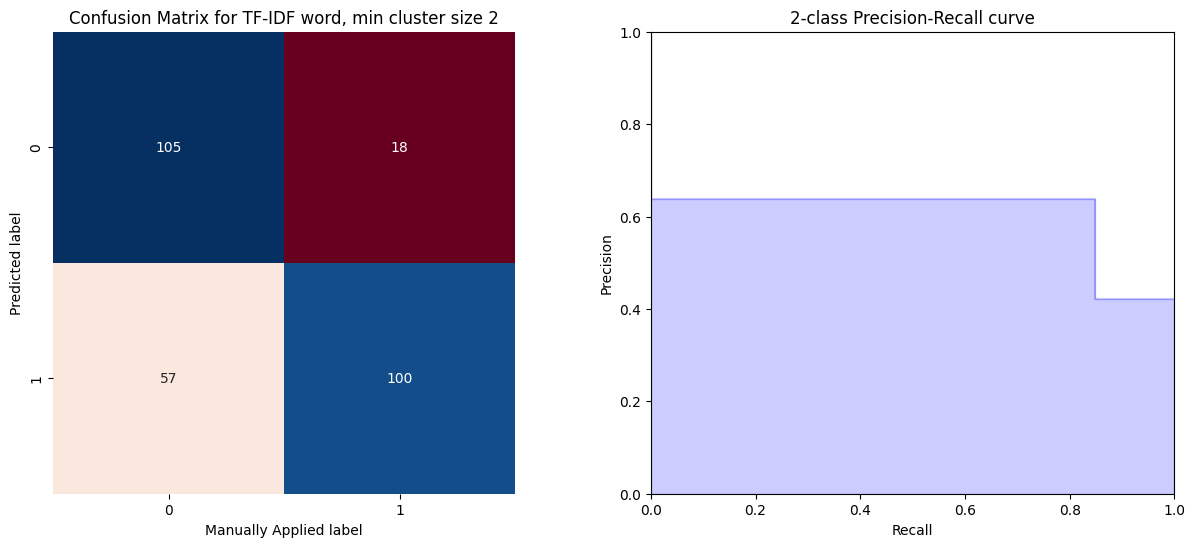

,"TF-IDF word, min cluster size 2"
Accuracy,0.732143
Precision,0.636943
Recall,0.847458
A.R.I.,0.212562
Homogeneity,0.191721
Completeness,0.190321
V-Measure,0.191019


In [309]:
report1 = reporter(y_test,preds2[0],"TF-IDF word, min cluster size 2")
display(report1)

### Word embedding with a 3 term window and min cluster size 7

Accuracy    : 0.7286 Proportion of estimated labels that match the applied labels.               Best: 1, Worst: 0
Precision   : 0.6842 Proportion of "relevant" predictions that are correctly matched.            Best: 1, Worst: 0
Recall      : 0.6610 Proportion of correct "relevant" predictions from all "relevant" instances. Best: 1, Worst: 0
ARI         : 0.2056 Similarity between class labels, 0 representing independence                Best: 1, Worst: -1
Homogeneity : 0.1461 How well each predicted group matches with a single true class.             Best: 1, Worst: 0
Completeness: 0.1472 How well all members of a true class are grouped in the predictions.        Best: 1, Worst: 0
V-Measure   : 0.1466 How well predictions match applied labels.                                  Best: 1, Worst: 0


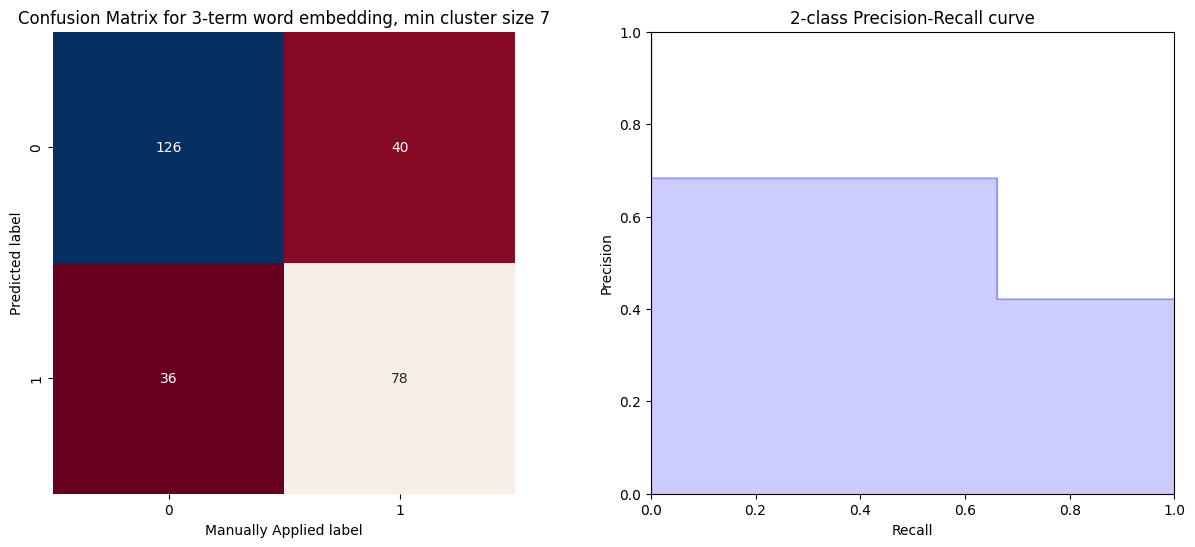

,"3-term word embedding, min cluster size 7"
Accuracy,0.728571
Precision,0.684211
Recall,0.661017
A.R.I.,0.205622
Homogeneity,0.146109
Completeness,0.147178
V-Measure,0.146642


In [310]:
report2 = reporter(y_test,preds6[5],"3-term word embedding, min cluster size 7")
display(report2)

### Word counts with min cluster size 10 (poor model -no training recall)

Accuracy    : 0.5786 Proportion of estimated labels that match the applied labels.               Best: 1, Worst: 0
Precision   : 0.0000 Proportion of "relevant" predictions that are correctly matched.            Best: 1, Worst: 0
Recall      : 0.0000 Proportion of correct "relevant" predictions from all "relevant" instances. Best: 1, Worst: 0
ARI         : 0.0000 Similarity between class labels, 0 representing independence                Best: 1, Worst: -1
Homogeneity : 0.0000 How well each predicted group matches with a single true class.             Best: 1, Worst: 0
Completeness: 1.0000 How well all members of a true class are grouped in the predictions.        Best: 1, Worst: 0
V-Measure   : 0.0000 How well predictions match applied labels.                                  Best: 1, Worst: 0


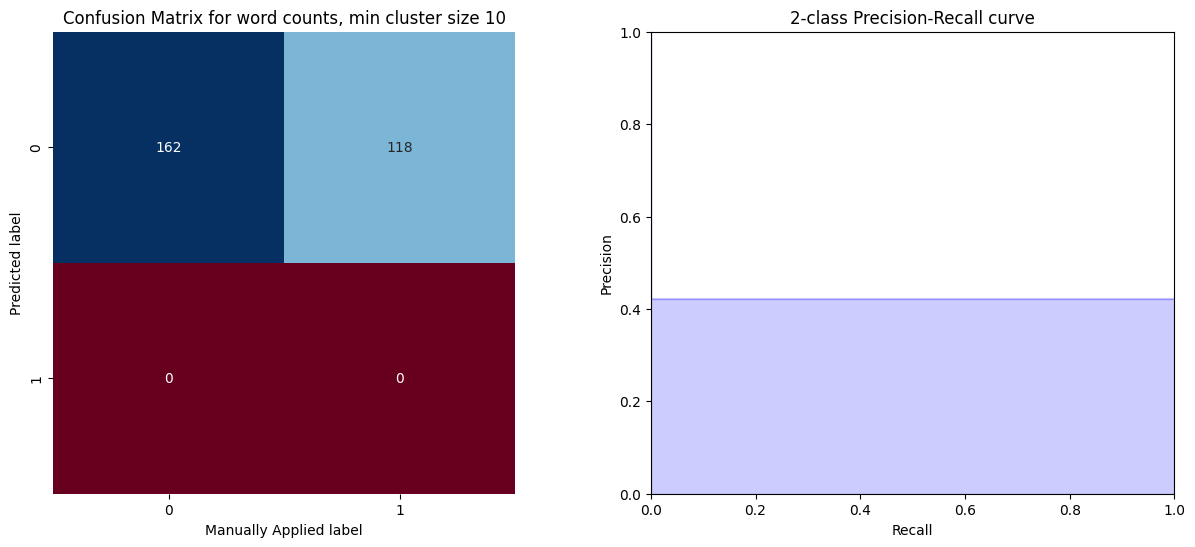

,"word counts, min cluster size 10"
Accuracy,0.578571
Precision,0.000000
Recall,0.000000
A.R.I.,0.000000
Homogeneity,0.000000
Completeness,1.000000
V-Measure,0.000000


In [329]:
report3 = reporter(y_test,preds4[8],"word counts, min cluster size 10")
display(report3)

### Parts of speech with min cluster size 10 (poor model-low recall)

Accuracy    : 0.5893 Proportion of estimated labels that match the applied labels.               Best: 1, Worst: 0
Precision   : 0.5882 Proportion of "relevant" predictions that are correctly matched.            Best: 1, Worst: 0
Recall      : 0.0847 Proportion of correct "relevant" predictions from all "relevant" instances. Best: 1, Worst: 0
ARI         : 0.0123 Similarity between class labels, 0 representing independence                Best: 1, Worst: -1
Homogeneity : 0.0053 How well each predicted group matches with a single true class.             Best: 1, Worst: 0
Completeness: 0.0159 How well all members of a true class are grouped in the predictions.        Best: 1, Worst: 0
V-Measure   : 0.0080 How well predictions match applied labels.                                  Best: 1, Worst: 0


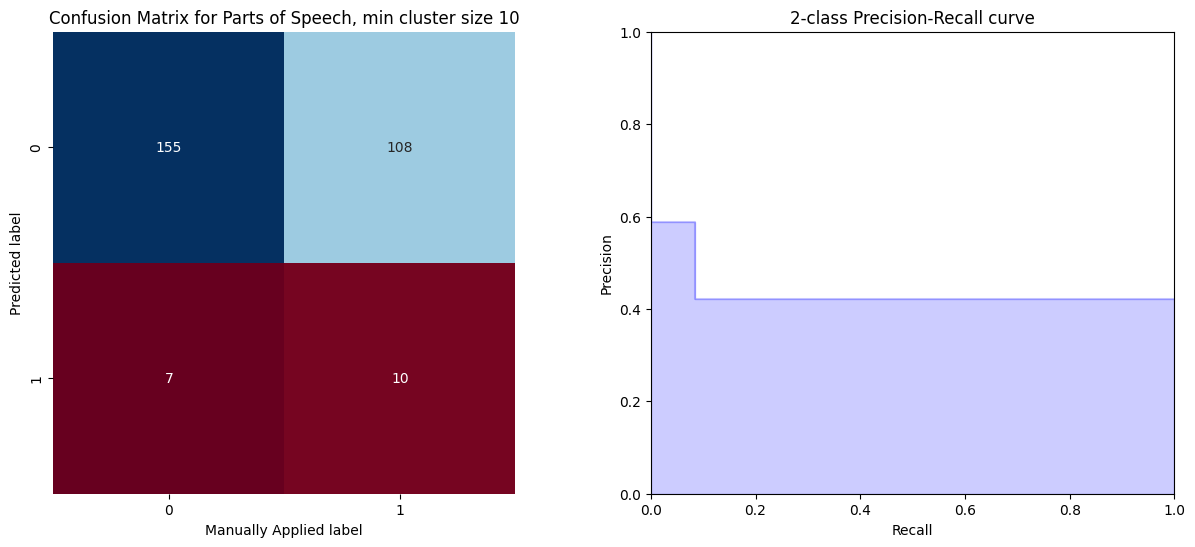

,"Parts of Speech, min cluster size 10"
Accuracy,0.589286
Precision,0.588235
Recall,0.084746
A.R.I.,0.012273
Homogeneity,0.005335
Completeness,0.015863
V-Measure,0.007984


In [330]:
report4 = reporter(y_test,preds1[8],"Parts of Speech, min cluster size 10")
display(report4)

### TF-IDF word: min cluster size 10 (High train recall)

Accuracy    : 0.6893 Proportion of estimated labels that match the applied labels.               Best: 1, Worst: 0
Precision   : 0.5812 Proportion of "relevant" predictions that are correctly matched.            Best: 1, Worst: 0
Recall      : 0.9407 Proportion of correct "relevant" predictions from all "relevant" instances. Best: 1, Worst: 0
ARI         : 0.1379 Similarity between class labels, 0 representing independence                Best: 1, Worst: -1
Homogeneity : 0.1901 How well each predicted group matches with a single true class.             Best: 1, Worst: 0
Completeness: 0.2069 How well all members of a true class are grouped in the predictions.        Best: 1, Worst: 0
V-Measure   : 0.1981 How well predictions match applied labels.                                  Best: 1, Worst: 0


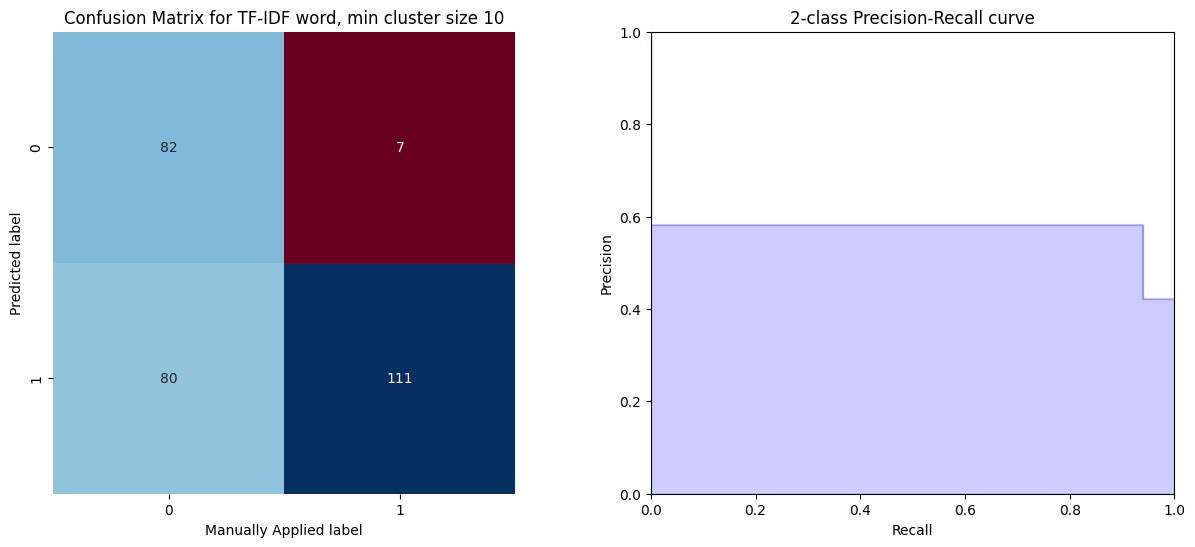

,"TF-IDF word, min cluster size 10"
Accuracy,0.689286
Precision,0.581152
Recall,0.940678
A.R.I.,0.137877
Homogeneity,0.190070
Completeness,0.206943
V-Measure,0.198148


In [331]:
report5 = reporter(y_test,preds2[8],"TF-IDF word, min cluster size 10")
display(report5)

## LLM summarising

In [332]:
with open(r"hf_token.txt", 'r') as file:  
    HUGGINGFACEHUB_API_TOKEN = file.read().strip()

In [333]:
from langchain_community.llms import HuggingFaceEndpoint

In [334]:
from langchain.chains import LLMChain
from langchain.prompts import PromptTemplate

In [335]:
mistral_url = f"https://api-inference.huggingface.co/models/mistralai/Mistral-7B-Instruct-v0.2"

mistral_llm = HuggingFaceEndpoint(
    task="text-generation",
    endpoint_url=mistral_url,
    model_kwargs = {"max_new_tokens": 800, "temperature": 0.5, "seed": 94},
    huggingfacehub_api_token = HUGGINGFACEHUB_API_TOKEN
)

In [336]:
mytemplate = """
<s>[INST]Summarize the following corpus into a coherent factual summary:

[CONVERSATION]

{corpus}

[END]

Note who the speakers are then summarize the key ideas, themes and topics discussed in the conversation including specific examples made, maintaining factual accuracy throughout.[/INST]{text}
"""
myprompt = PromptTemplate.from_template(mytemplate)
llm_chain = LLMChain(prompt=myprompt, llm=mistral_llm)

In [362]:
def final_filter(clusters,mapping,DF):
    strings = DF[clusters.isin(mapping)].Text
    return strings

### Manual labelling

In [337]:
print(llm_chain.invoke({'corpus':ep1_labelled.loc[ep1_labelled['Label'] == 1, 'Text'],'text':''})['text'])

In this episode of StarTalk, Neil deGrasse Tyson is hosting a conversation with his friend and colleague, Michio Kaku, about the future of quantum computing. Michio Kaku is the author of the book "Quantum Supremacy." The speakers discuss how the world is already undergoing significant changes and how quantum computing will accelerate this transformation. They wonder aloud if humanity is smart enough to fully understand and harness the potential of quantum computing. Kaku's book, "Quantum Supremacy," serves as a roadmap into this future. The conversation touches on the potential implications of quantum computing, including its ability to solve complex problems that are currently unsolvable with classical computers. They also discuss the potential challenges and limitations of quantum computing, such as the need for extremely low temperatures to operate. Overall, the conversation explores the exciting and potentially game-changing possibilities of quantum computing and the role it will p

### TF-IDF word: min cluster size 2

In [364]:
print(llm_chain.invoke({'corpus':final_filter(ep1_TFIDFword_clusters.iloc[:,0],maps2[0],ep1_labelled),'text':''})['text'])

This conversation is from an episode of StarTalk, a podcast or radio show, where the host Neil deGrasse Tyson is joined by his co-host Jordan Klepper and a guest, Mic, to discuss the future of quantum computing. The episode begins with the standard StarTalk introduction. The speakers express wonder about the implications of recent discoveries and question whether humanity is intelligent enough to fully comprehend the universe. They specifically discuss quantum computing and its potential impact on society and human understanding of the universe. No specific examples were mentioned in the provided text.


### Word embedding with a 3 term window and min cluster size 7

In [365]:
print(llm_chain.invoke({'corpus':final_filter(ep1_word3embed_clusters.iloc[:,5],maps6[5],ep1_labelled),'text':''})['text'])

In this episode of StarTalk, the host Neil deGrasse Tyson is joined by his co-host Jordan Klepper, and his friend and colleague Micah Hesse. The topic of the discussion is the future of quantum computing. To add some controversy to the conversation, they also have a special guest.

Throughout the conversation, they ponder upon the implications of various scientific discoveries and advancements from a cosmic perspective. They ask thought-provoking questions such as, "Are we smart enough as a species to even know what the right questions are to ask about the universe?" and "With all of these discoveries, are we actually smart enough to answer the questions we pose?"

Examples of scientific discoveries and advancements discussed include the discovery of dark energy and dark matter, the potential for multiverse theories, and the development of quantum computing. They also touch upon the potential implications of these discoveries for humanity, such as the possibility of creating advanced a

### Parts of Speech with min cluster size 10 (low recall example)

In [366]:
print(llm_chain.invoke({'corpus':final_filter(ep1_pos_clusters.iloc[:,8],maps1[8],ep1_labelled),'text':''})['text'])

Speaker 1: For most of human existence, life was difficult. However, we have made advancements such as creating generators and power plants.

Speaker 2: (Interrupting) Did he say "bitch"? (It is unclear if Speaker 1 used that term in its colloquial, derogatory sense or if they were referring to life being difficult in a figurative way)

Speaker 1: Continuing, these advancements have led to whole branches of society.

Speaker 2: We now harness energy directly from the sun through advanced technology.

Speaker 1: And we are pondering whether humanity has reached Type III civilization in the Kardashev scale, which is capable of harnessing all the energy of its planet.

Speaker 2: When will we become a Type I civilization, capable of harnessing all the energy available on our planet?

Speaker 1: We need to consider if we are smart enough to answer such questions.

The conversation revolves around the challenges of human existence, the advancements we've made in technology, and our place in

### TF-IDF word: min cluster size 10 (High train recall example)

In [367]:
print(llm_chain.invoke({'corpus':final_filter(ep1_TFIDFword_clusters.iloc[:,8],maps2[8],ep1_labelled),'text':''})['text'])

In this conversation, the speakers are Neil deGrasse Tyson, Jordan Klepper, and Mic. They are introducing an episode of StarTalk, during which they discuss the future of quantum computing. The conversation touches upon the limitations of human intelligence in understanding the universe's complexities, with Jordan Klepper expressing curiosity about whether humans are smart enough to answer fundamental questions, such as those related to quantum computing. The panelists ponder the significance of recent scientific discoveries and the cosmic perspective they provide, acknowledging the grand scale of the universe and the challenges it poses to human understanding. The conversation does not provide specific examples or facts related to quantum computing, but rather focuses on the broader implications of scientific advancements and the role of human intelligence in comprehending them.


### Counts with min size 2 (extremely low recall example)

In [368]:
print(llm_chain.invoke({'corpus':final_filter(ep1_Count_clusters.iloc[:,0],maps4[0],ep1_labelled),'text':''})['text'])

The conversation does not contain any spoken text or identifiable speakers. The numbers likely represent line numbers or indices in a larger dataset, and the words "quantum," "superposition," "nothing continuous," "pioneer," and "Mico quantum equality" appear several times. Based on the context of these terms, we can infer that the conversation relates to the field of quantum physics.

The key ideas and topics discussed in the conversation include:

1. The concept of "quantum" and its role in physics.
2. The idea that quantum systems do not behave in a continuous manner, but rather exist in discrete states.
3. The concept of a "superposition," which refers to a quantum system that exists in multiple states at once.
4. The recognition of someone as a "pioneer" in the field of quantum physics.
5. The possible existence of a "Mico quantum equality," but the context of this term is unclear.

Therefore, the conversation revolves around the fundamental principles of quantum physics and the c

## Growth & Next Steps

The next step from here is clearly to expand the training base, both for the initial clustering to establish more diversity and increase robustness and for the mapping or filtering of those cluster labels into a reliable filter for future transcripts. Investigating further feature engineering processes designed more to increase recall than accuracy would also prove beneficial. The process at the moment is also quite disjointed and piece-wise, so bringing into a streamlined pipeline would be advantageous particularly if looking to adapt or further the work into an application or website for providing useful scientific updates for perhaps even other programmes or sources. Another area for growth would be an exploration into broken speech. being able to joint or finish incomplete sentences or phrases may be able to uncover information that would otherwise be relegated to the disgard pile. In this project there were many examples of sentences that had been interrupted or suffered from transcription error due to the difficulty of algorithms to fully comprehend conversational speech. In our labelled episode, the main guest was often referred to as Mico, Mic, or Michael when his name is Michio Kaku this resulted in different models stating different guests were present. The ability to establish baseline facts and weight them appropriately might also help to refine the models.
